<a href="https://colab.research.google.com/github/inforeqd512/QLearning/blob/main/RL_TicTacToe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import numpy as np
import pylab as plt

# Game

Every simulation starts with a new Game _Board_. 

Each iteration of the simulation ends when the board is full or when any of the players wins.

Every Player _Agent_ is setup with their _Policy Trainer_ and follows espilon greedy policy to learn best actions over several iterations of the simulation.

**measure of success** : The Players become good at playing when the 'Draw' percentages are high.. ie. the first player to go learns to play in the middle or lears to play to Draw

It takes approximately 5000 iterations to get to optimal q-values. At that time both players learn the game well enough to win approx 50% of the time. 

### Actors in the Game


_Board_ is the environment. _State_ is the position of the board after a move from any player. Board also provides the possible set of actions. These are set of open positions on the board on which the player can put it's symbol. 

_Agent_ is the player playing the game. 

- Player playing $X$ will be denoted by symbol $1$
- Player playing $O$ will be denoted by symbol $-1$

Every _Agent_ has its own _Policy Trainer_ that learns the best action it should do in the _Board_ environment. 

The _Policy_Trainer_ follows is the epsilon greedy random policy to choose the next action. Based on this policy it learns the _Quality Action or Q-table_ for each player. Typically the Q-values of Player X are different to those of Player O. 

The _Policy_Trainer_ also needs to update the Q-values after performing the action and seeing the reward, so the _Agent_ delegates the choosing of the action and the performing of the action to it. 


_Action_ to be performed is chosen by the agent on the current state of the board. It is the next available position on the board that the agent can choose from. 

        


### Exploration and Exploitation

Initially we explore more as we learn about the possible moves that can be made. Over multiple iterations we start exploiting what we've learnt so we decay the exploration factor epsilon. 

**Decaying epsilon-greedy**: Does the same as epsilon-greedy, however, the epsilon value starts out near 1, and decays over time according to γ to power of x where x represents the iteration the agent is in.  For γ 0.99 is used 

<sup>Source: [The Effect of the Exploration
Strategy on an Agent’s Performance](https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp,%20T._BSc_Thesis_2017.pdf?sequence=1) from Thijs Nieuwdorp</sup>

### Quality of Action 

**Q (dict)** - 

- key = state hash, 
- value = is an array representing 9 spaces in the tic tac toe grid,

Starting from top row of grid, from left to right then next row from left to right etc, based on the grid position sent as input action, the array index is computed
      
eg 
- for 0,1 grid position = 0 * 3 (number of rows and cols in grid) + 1 == 1 so the index of 1.. ie at position 2 in the array
- for 1,1 grid position = 1 * 3 + 1 == 4 so 0,1,2,3,4th position in the array 

beware!!! when using the default initialisation of parameter as {} then python allocates the same memory to both instances of PolicyTrainer. As a result both policies showed the same scores. Also showed win for 1 when should show only for -1.. The best way to find this happening is to initialise the game state to a board where only one player can win, but you'll see that both players get a non-zero Q-value


# Board

In [139]:
class Board:
  """ Class that represents the game board of Tic Tac Toe """

  playerX = 1
  playerO = -1

  def __init__(self, rows=3, cols=3):
    self.rows = rows
    self.cols = cols 
    self.state = np.zeros((self.rows, self.cols), dtype=np.int8)
    # self.state = np.array(
    #               [[0,  0, -1],
    #                [0,  1,  1],
    #                [-1, 1, -1]])
    
  def showBoard(self):
    # p1: x  p2: o
    for i in range(0, self.rows):
        print('-------------')
        out = '| '
        for j in range(0, self.cols):
            if self.state[i, j] == 1:
                token = 'x'
            if self.state[i, j] == -1:
                token = 'o'
            if self.state[i, j] == 0:
                token = ' '
            out += token + ' | '
        print(out)
    print('-------------')


  def checkWinner(self):
    """  return winner symbol, if one exists. 0 if no winner"""

    symbols = np.unique(self.state) #unique values , 0, 1, -1
    symbols = symbols[np.nonzero(symbols)] #remove 0's
    winning_symbol = 0 #no winner yet

    for symbol in symbols:
      #check rows
      row = np.any(np.all(self.state == symbol, axis=1))

      #check cols
      col = np.any(np.all(self.state == symbol, axis=0))

      #check diagonals
      diag1 = np.array([self.state[0,0], self.state[1,1], self.state[2,2]])
      diag1 = np.all(diag1 == symbol)

      diag2 = np.array([self.state[2,0], self.state[1,1], self.state[0,2]])
      diag2 = np.all(diag2 == symbol)

      # Check if state has winner and return winner in that case
      if row or col or diag1 or diag2:
        winning_symbol = symbol
        break
  
    return winning_symbol

  def getAvailablePos(self):
    """  Get state positions that have no value ie zeros """
    return np.argwhere(self.state == 0)

  def isBoardFull(self):
    return (len(self.getAvailablePos()) == 0)

  def checkGameEnded(self):
    """ Check if game has ended by observing if there any possible moves left
    or there is a winner """
    ended = (self.isBoardFull()) or (self.checkWinner() != 0)
    return ended

  def setPosition(self, x, y, symbol):
    """  Set state at position (x,y) with symbol """
    self.state[x,y] = symbol

  def getStateHash(self):
    """  Get hash key of state """
    boardHash = str(self.state.reshape(self.rows * self.cols))
    return boardHash
  
  def performAction(self, action_to_perform, symbol):
    """  Perform the action on current board """
    self.setPosition(action_to_perform[0], action_to_perform[1], symbol)
    return self
      

In [140]:
class Agent:
  """ Class that represents the player 
      symbol is 1 for 'X' or -1 for 'O' 
      policy_trainer is initialised with epsilon greedy set to exploration_probability which is reduced overtime"""

  def __init__(self, symbol, exploration_probability):
    self.symbol = symbol
    self.policy_trainer = PolicyTrainer(exploration_probability=exploration_probability, symbol=symbol)
    return

  def performActionPerPolicy(self, state_hash, possible_actions, current_state):
    """ per the explore and exploitation with current epsilon """
    next_action = self.policy_trainer.chooseAction(state_hash, possible_actions)
    self.policy_trainer.performAction(current_state, next_action)

  def applyFinalResult(self, game_board):
    """
      Gets called after the game has finished. Will update the current Q function based on the game outcome.
    """
    self.policy_trainer.applyFinalResult(game_board)

  def epsilonDecayPerIterations(self, num_iterations):
    """ gradually reduces probabilities per iteration but not completely eliminate it"""
    # Reduce probability to explore during training
    # Do not remove completely 
    
    # Decaying epsilon-greedy: Does the same as epsilon-greedy, however, the epsilon value starts out near 1,
    # and decays over time according to γ to power of x where x represents the iteration the agent is in. 
    # For γ 0.99 is used per https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp,%20T._BSc_Thesis_2017.pdf?sequence=1
        
    if self.policy_trainer.exploration_probability > 0.2:
      decay = 0.99 ** num_iterations
      self.policy_trainer.exploration_probability = decay
      print("self.policy_trainer.exploration_probability :", self.policy_trainer.exploration_probability)

  def updateScore(self):
    """ measures how much is the q-values changing over iterations till finally they settle """
    self.policy_trainer.updateScore()

  def newGame(self):
    self.policy_trainer.newGame()

In [141]:
class PolicyTrainer:
  """
      exploration_probability (float) epsilon greedy value
      learning_rate (float)
      discount_factor (float)
      Q (dict) - {state_hash : array of grid positions}
  """
  def __init__(self, symbol, exploration_probability, learning_rate = 0.9, discount_factor = 0.9, grid_size = 3):
    self.Q = {} #beware!!! when using the initiatlisation value a {} then python allocates the same one to both policies
    self.learning_rate = 1.0 #learning_rate
    self.discount_factor = discount_factor
    self.exploration_probability = exploration_probability
    self.grid_size = grid_size
    self.scores = []
    self.symbol = symbol
    self.num_times_states_seen = {}
    self.move_history = [] #type: List[(state_hash, action)] keeps a history of all moves done to back propagate the reward
    return

  def getActionIndex(self, current_action):
    """ Returns index in the action array position where the q value should be put """
    idx = self.grid_size * current_action[0] + current_action[1]
    return idx

  def getQValues(self, current_state_hash) -> np.ndarray:
    if current_state_hash not in self.Q:
      self.Q[current_state_hash] = np.zeros(self.grid_size * self.grid_size)
    q_values = self.Q[current_state_hash]
    return q_values

  def getValueQ(self, current_state_hash, current_action) -> float:
    """ Get the quality value of a given action in a given state,
            returns 0 if the state-action pair has not been seen before and in this case it adds that state into the Q table
            Input is state hash key
            and action as an array of position where the symbol should be put ie [0,1] for top row middle square"""
    idx = self.getActionIndex(current_action)
    q_value = 0.0
    if current_state_hash in self.Q:
      q_value = self.Q[current_state_hash][idx]
    else:
      self.setValueQ(current_state_hash, current_action, q_value)
      
    return q_value

  def setValueQ(self, current_state_hash, current_action, value):
    """ Set value in Q 
    if this is the first time the state is seen, then the value is the array representing the grid"""
    idx = self.getActionIndex(current_action)
    if current_state_hash in self.Q:
      self.Q[current_state_hash][idx] = value
    else:
      self.Q[current_state_hash] = np.zeros(self.grid_size * self.grid_size)
      self.Q[current_state_hash][idx] = value
    return

  def rewardFunction(self, game_board):
    """ when the chosen action is performed on a state, then we get a new state
    and associated reward from this transition is computed here
    if next state is winner then reward is 1 else -1 if loses to the opponent or 0.5 if draw """
    
    reward = 0 
    winner = game_board.checkWinner() # Returns 0 if there is no winner
    if winner != 0: #winner is when it's 1 or -1
      if winner == self.symbol:
          reward = 1
      else:
          reward = -1
    elif game_board.isBoardFull(): #if the game finishes but there is no winner, then reward is 0.5 for draw
      reward = 0.5

    return reward

  def chooseAction(self, state_hash, possible_actions):
    """ choose action per epsilon greedy explore/exploit policy """
    #Explore
    if random.random() < self.exploration_probability:
      action = self.chooseRandomAction(possible_actions)
    else:
      #Exploit
      action = self.chooseBestAction(state_hash, possible_actions)

    if state_hash == '[0 0 0 0 0 0 0 0 0]' and self.symbol == 1:
      print(state_hash, " ", action)
    return action

  def chooseRandomAction(self, possible_actions):
    """ choose random action from list of possible actions in a state """
    random_idx = np.random.choice(possible_actions.shape[0]) #range from count of possible actions eg 6 actions then [0...5]
    action_pos = possible_actions[random_idx]
    return action_pos

  def chooseBestAction(self, current_state_hash, possible_actions):
    """ Get best action given a set of possible actions in a given state """
    # Pick a random action at first
    random_idx = np.random.choice(possible_actions.shape[0])
    best_action = possible_actions[random_idx]

    # Find action that given largest Q in given state
    maxQ = 0 
    for action in possible_actions:
      tmpQ = self.getValueQ(current_state_hash, action)
      if maxQ < tmpQ:
        maxQ = tmpQ
        best_action = action

    return best_action

  def performAction(self, current_state, next_action):
    """ make the move on the board but defer calculating the Q till the end as 
        only at the end will we know the reward and so the true value of these steps
    """
    self.move_history.append((current_state.getStateHash(), next_action))
    next_state = current_state.performAction(next_action, self.symbol)

  def applyFinalResult(self, game_board):
    """ Implements Q-learning iterative algorithm 
    back propagate the reward to the states that the player sees/moves. 
    Back propagation is required as the player can judge the value of the moves only at the end
    also since the other player is making every alternate view, calculating q value when he makes the move is not possible for the first player
    as the policy of the other player makes that move, and q-learning calculation done at that time only applies to the other player
    and by the time the first player sees the move it does not remember the last move to adjust the q_value of that move wrt the other players move
    easy to do this at the end of all moves
    """
    reward = self.rewardFunction(game_board)

    self.move_history.reverse()

    next_maxQ = None #type: float
    
    for (state_hash, action) in self.move_history:
      q_values = self.getQValues(state_hash)
      idx = self.getActionIndex(action)
      if next_maxQ == None: #first time in the loop
        q_values[idx] = reward #as this is action that led to terminal state (win lose or draw), it gets the final reward TODO: should I add the reward
      else:
        q_values[idx] = q_values[idx] * (1 - self.learning_rate) + self.learning_rate * (0 + self.discount_factor * next_maxQ) #intermediate rewards is zero
      next_maxQ = max(q_values)

    if self.symbol == 1:
      for (state_hash, _) in self.move_history:
        q_values = self.getQValues(state_hash)
        print(state_hash, " ", q_values)
      print("final result :", self.symbol, reward, self.move_history)


  def newGame(self):
    """
    Called when a new game is about to start. Reset our internal game state.
    """
    self.move_history = []

  def updateScore(self):
    #compute score
    score = 0
    list1 = list(self.Q.values())
    score = np.sum(list1)
    self.scores.append(score)


# Q-Learning : Training

In [142]:
from tqdm import tqdm
import random

In [143]:
def playGame(game_board, playerX, playerO):
  playerX.newGame()
  playerO.newGame()

  # Pick current player
  current_player = playerX

  # play full games in each iteration
  while not game_board.checkGameEnded():
    possible_actions = game_board.getAvailablePos()
    state_hash = game_board.getStateHash()

    current_player.performActionPerPolicy(state_hash, possible_actions, game_board)
    # print(current_player.symbol, " after move")
    # game_board.showBoard()
    
    # Swap player
    if current_player == playerX:
        current_player = playerO
    else:
        current_player = playerX

  playerX.applyFinalResult(game_board)
  playerO.applyFinalResult(game_board)

def simulate(iterations):
  """ iterations (int) """

 # Epsilon-greedy 
  exploration_probability = 1.0

  # Initiatlise players
  playerX = Agent(Board.playerX, exploration_probability)
  playerO = Agent(Board.playerO, exploration_probability)

  # Counters for wins of each agent and total number of games
  nbr_wins_playerX = 0
  nbr_wins_playerO = 0
  nbr_draw = 0
  nbr_games = 100
  if iterations > nbr_games:
    nbr_battles = int(iterations/nbr_games)
  else:
    nbr_battles = 1

  for i in tqdm(range(nbr_battles)):

    for j in range(nbr_games):
      # Construct game board and reset player states
      print("\nNew Game")
      game = Board()
      playGame(game, playerX, playerO)

      # Check if there is a winner
      winner = game.checkWinner() # Returns 0 if there is no winner
      if winner == playerX.symbol:
        print("X wins")
        nbr_wins_playerX += 1
      elif winner == playerO.symbol:
        print("O wins")
        nbr_wins_playerO += 1
      else:
        print("Draw game")
        nbr_draw += 1

      #when the full game is finished or there is a winner, then reset game and increment and print metrics
      # playerX.updateScore()
      # playerO.updateScore()

    playerX.epsilonDecayPerIterations(nbr_battles)
    playerO.epsilonDecayPerIterations(nbr_battles)
    
  # Print outcome
  nbr_total_games = nbr_battles * nbr_games
  print("\n\nWins: Agent X : ", nbr_wins_playerX, "Wins: Agent O : ", nbr_wins_playerO, "Total Games : ", nbr_total_games)    
  print("\nWin percentage: Agent X {:.2%}, Agent O {:.2%}.".format(nbr_wins_playerX/nbr_total_games, nbr_wins_playerO/nbr_total_games))
  print("\nDraw percentage: {:.2%} ".format(nbr_draw/nbr_total_games))

  return (playerX, playerO)



# Q-Learning : Training

In [144]:
(playerX, playerO) = simulate(10000)

  0%|          | 0/100 [00:00<?, ?it/s]


New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 1 -1 -1  1  0  0  0 -1  1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 0 -1 -1  1  0  0  0  0  1]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  0  0  0  0  1]   [0.00 0.00 0.00 0.81 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.73]
final result : 1 1 [('[ 1 -1 -1  1  0  0  0 -1  1]', array([1, 1])), ('[ 0 -1 -1  1  0  0  0  0  1]', array([0, 0])), ('[ 0  0 -1  0  0  0  0  0  1]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1  0  1  0 -1  0  0 -1  0]   [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  1  0 -1  0  0  0  0]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.00 0.00 0.81 0.00 0.00 0.00 0.00 0.00 0.73]
final result : 1 1 [('[ 1  0  1  0 -1  0  0 -1  0]', array([0, 1])), ('[ 0  0  1  0 -1  0  0  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 

  1%|          | 1/100 [00:01<02:42,  1.65s/it]

[ 1  1  0  1  0 -1 -1 -1  0]   [0.00 0.00 1.00 0.00 -1.00 0.00 0.00 0.00 0.00]
[ 1  0  0  1  0 -1  0 -1  0]   [0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  0  0  0  0  0 -1  0]   [0.00 0.00 0.00 0.81 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.00 0.73 0.73 0.73 0.73 0.73 0.73]
final result : 1 1 [('[ 1  1  0  1  0 -1 -1 -1  0]', array([0, 2])), ('[ 1  0  0  1  0 -1  0 -1  0]', array([0, 1])), ('[ 1  0  0  0  0  0  0 -1  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[ 0  1 -1  1 -1 -1  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.00]
[ 0  0 -1  1 -1  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0 -1  1  0  0  0  0  0]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.00 0.81 0.73 0.73 0.73 0.73 0.73]
final result : 1 -1 [('[ 0  1 -1  1 -1 -1  1  0  0]', array([2, 1])), ('[ 0  0 -1  1 -1  0  1  0  0]', array([0, 1])), ('[ 0  0 -1  1  0  0 

  2%|▏         | 2/100 [00:03<02:43,  1.67s/it]

X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 1 -1 -1 -1 -1  1  1  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 0 -1 -1 -1  0  1  1  1  0]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1 -1  0  0  0  1  1  0]   [0.00 0.00 0.00 0.00 0.00 0.81 0.00 0.00 0.00]
[ 0  0 -1  0  0  0  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.36 0.73 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.00 0.00 0.33 0.33 0.33 0.33 0.66 0.66]
final result : 1 1 [('[ 1 -1 -1 -1 -1  1  1  1  0]', array([2, 2])), ('[ 0 -1 -1 -1  0  1  1  1  0]', array([0, 0])), ('[ 0 -1 -1  0  0  0  1  1  0]', array([1, 2])), ('[ 0  0 -1  0  0  0  0  1  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0  0  1 -1  1  1 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 0  0  1 -1  1  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 0  0  0  0  1  0  0 -1  0]   [0.00 0.00 0.81 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.00 0.00 0

  3%|▎         | 3/100 [00:05<02:42,  1.68s/it]

[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  0  1 -1  0  0  1  0  0]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 0  0  0 -1  0  0  1  0  0]   [0.36 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.00 0.00 0.00 0.66 0.81 0.00 0.73]
final result : 1 1 [('[-1  0  1 -1  0  0  1  0  0]', array([1, 1])), ('[ 0  0  0 -1  0  0  1  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[ 1 -1  1 -1  0  0  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00]
[ 1 -1  0  0  0  0  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1  0  0  0  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.73 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.00 0.00 0.00 0.66 0.66 0.00 0.73]
final result : 1 -1 [('[ 1 -1  1 -1  0  0  1 -1  0]', array([1, 2])), ('[ 1 -1  0  0  0  0  1 -1  0]', array([0, 2])), ('[ 0 -1  0  0  0  0  1  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 

  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]


New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0  0  1  0  1  0  0 -1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 0  0  0  0  1  0  0 -1  0]   [0.00 0.00 0.90 0.73 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.00 0.33 0.66 0.81 0.33 0.00 0.66 0.33]
final result : 1 1 [('[ 0  0  1  0  1  0  0 -1 -1]', array([2, 0])), ('[ 0  0  0  0  1  0  0 -1  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 2]
[-1  1 -1 -1 -1  1  1  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 0  1 -1 -1 -1  1  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00]
[ 0  0 -1 -1  0  1  0  1  0]   [0.00 0.81 0.00 0.00 0.00 0.00 0.41 0.00 0.00]
[ 0  0  0 -1  0  1  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.73 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.00 0.33 0.66 0.81 0.66 0.00 0.66 0.33]
final result : 1 1 [('[-1  1 -1 -1 -1  1  1  1  0]', array([2, 2])), ('[ 0  1 -1 -1 -1  1  0  1  0]', array([2, 0])), ('[ 0  0 -1 -1  0  1  0  1  0]', ar

  5%|▌         | 5/100 [00:08<02:37,  1.66s/it]


final result : 1 1 [('[-1 -1  1  1  0  1  1 -1 -1]', array([1, 1])), ('[-1 -1  0  1  0  1  1 -1  0]', array([0, 2])), ('[-1  0  0  0  0  1  1 -1  0]', array([1, 0])), ('[-1  0  0  0  0  1  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[-1  1  1 -1 -1  1  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[-1  1  0 -1 -1  1  1  0  0]   [0.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0 -1 -1  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.81 0.00 0.00 0.00]
[ 0  1  0  0 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.73 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.33 0.33 0.66 0.66 0.33 0.66 0.66]
final result : 1 1 [('[-1  1  1 -1 -1  1  1 -1  0]', array([2, 2])), ('[-1  1  0 -1 -1  1  1  0  0]', array([0, 2])), ('[ 0  1  0 -1 -1  0  1  0  0]', array([1, 2])), ('[ 0  1  0  0 -1  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
X wins
self.policy_trainer.exploration_probability : 0.366032

  6%|▌         | 6/100 [00:09<02:35,  1.65s/it]

[ 1  1  0  1 -1 -1 -1  1 -1]   [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  0  1 -1 -1  0  1 -1]   [0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  1 -1  0  0  1 -1]   [0.81 0.00 0.00 0.00 0.00 0.00 0.81 0.00 0.00]
[ 0  0  0  0  0  0  0  1 -1]   [0.00 0.00 0.00 0.73 0.00 0.36 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.00 0.33 0.66 0.00 0.33 0.66 0.33]
final result : 1 1 [('[ 1  1  0  1 -1 -1 -1  1 -1]', array([0, 2])), ('[ 1  0  0  1 -1 -1  0  1 -1]', array([0, 1])), ('[ 0  0  0  1 -1  0  0  1 -1]', array([0, 0])), ('[ 0  0  0  0  0  0  0  1 -1]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0  0  1  0  1  0  0 -1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 0  0  0  0  1  0  0  0 -1]   [0.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.00 0.33 0.81 0.00 0.33 0.66 0.33]
final result : 1 1 [('[ 0  0  1  0  1  0  0 -1 -1]', array([2, 0])), ('[ 0  0  0  0  1  0  0 

  7%|▋         | 7/100 [00:11<02:30,  1.62s/it]

[ 0  1  1 -1  0 -1  0 -1  1]   [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  1 -1  0  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.90]
[ 0  0  1  0  0  0  0 -1  0]   [0.00 0.81 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.73 0.33 0.33 0.00 0.66 0.66]
final result : 1 1 [('[ 0  1  1 -1  0 -1  0 -1  1]', array([0, 0])), ('[ 0  1  1 -1  0  0  0 -1  0]', array([2, 2])), ('[ 0  0  1  0  0  0  0 -1  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0  1  1  0 -1  0  0  0 -1]   [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  1  0  0  0  0  0 -1]   [0.00 0.90 0.00 0.36 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.81 0.73 0.33 0.33 0.00 0.66 0.66]
final result : 1 1 [('[ 0  1  1  0 -1  0  0  0 -1]', array([0, 0])), ('[ 0  0  1  0  0  0 

  8%|▊         | 8/100 [00:13<02:26,  1.59s/it]

[-1  1  1  0  1 -1 -1 -1  1]   [0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00]
[-1  1  1  0  1  0 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.45]
[ 0  0  1  0  1  0 -1 -1  0]   [0.00 0.41 0.00 0.81 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  1  0  0 -1  0]   [0.81 0.73 0.73 0.73 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.00 0.73 0.66 0.66 0.00 0.33]
final result : 1 0.5 [('[-1  1  1  0  1 -1 -1 -1  1]', array([1, 0])), ('[-1  1  1  0  1  0 -1 -1  0]', array([2, 2])), ('[ 0  0  1  0  1  0 -1 -1  0]', array([0, 1])), ('[ 0  0  0  0  1  0  0 -1  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
7  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 1  0 -1  1  1  0 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 1  0 -1  0  1  0  0 -1  0]   [0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00 1.00]
[ 0  0  0  0  1  0  0 -1  0]   [0.90 0.73 0.73 0.73 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.00 0.81 0.66 0.66 0.00 0.33]
final r

  9%|▉         | 9/100 [00:14<02:27,  1.62s/it]

  [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  0  0  1 -1  0]   [0.00 0.36 0.00 0.00 0.00 0.00 0.00 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.66 0.33 0.33 0.00 0.66 0.66 0.66 0.66 0.33]
final result : 1 -1 [('[ 1 -1  0 -1  0  1  1 -1  0]', array([0, 2])), ('[ 1 -1  0  0  0  0  1 -1  0]', array([1, 2])), ('[ 0  0  0  0  0  0  1 -1  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  0 -1  1 -1  0  1]   [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1 -1  0  0 -1  1  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.90]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.00 0.36 0.36 0.81 0.73 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.33 0.00 0.66 0.66 0.66 0.66 0.33]
final result : 1 1 [('[ 1 -1  0  0 -1  1 -1  0  1]', array([0, 2])), ('[ 1 -1  0  0 -1  1  0  0  0]', array([2, 2])), ('[ 1 -1  0  0  0  0  0  0  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0

 10%|█         | 10/100 [00:16<02:27,  1.64s/it]

 [('[ 1  0  0 -1  1 -1 -1  1  0]', array([0, 1])), ('[ 1  0  0 -1  0 -1  0  1  0]', array([1, 1])), ('[ 0  0  0 -1  0  0  0  1  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  1  1 -1  0  1  0  0 -1]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00]
[-1  1  1  0  0  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  1  0  0  0  0  0 -1]   [0.00 0.00 0.00 0.36 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.00 0.33 0.00 0.33 0.73 0.33]
final result : 1 -1 [('[-1  1  1 -1  0  1  0  0 -1]', array([1, 1])), ('[-1  1  1  0  0  0  0  0 -1]', array([1, 2])), ('[ 0  0  1  0  0  0  0  0 -1]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 1 -1  1 -1 -1  1  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00]
[ 1 -1  1 -1  0  0  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.45 0.00 0.00 0.00]
[ 1  0  0 -1  0  0  0  1 -1]   [0.00 0.00 0.41 0.00 0

 11%|█         | 11/100 [00:18<02:25,  1.63s/it]


[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0 -1  1  0  0  0  1  0 -1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 0 -1  1  0  0  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.90 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.81 0.33 0.33 0.73 0.33 0.33 0.33]
final result : 1 1 [('[ 0 -1  1  0  0  0  1  0 -1]', array([1, 1])), ('[ 0 -1  1  0  0  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1  0  1 -1 -1  1  0 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 1  0  1 -1  0  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 0  0  1 -1  0  0  0  0  0]   [0.81 0.00 0.00 0.00 0.00 0.36 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.33 0.33 0.73 0.33 0.33 0.33]
final result : 1 1 [('[ 1  0  1 -1 -1  1  0 -1  0]', array([2, 2])), ('[ 1  0  1 -1  0  0  0 -1  0]', array([1, 2])), ('[ 0  0  1 -1  0  0  0  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0

 12%|█▏        | 12/100 [00:19<02:22,  1.62s/it]

[ 0 -1  1  1  1  0 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]
[ 0 -1  1  1  0  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[ 0  0  0  1  0  0  0 -1  0]   [0.00 0.00 0.81 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.73 0.81 0.73 0.66 0.33 0.33]
final result : 1 1 [('[ 0 -1  1  1  1  0 -1 -1  0]', array([1, 2])), ('[ 0 -1  1  1  0  0  0 -1  0]', array([1, 1])), ('[ 0  0  0  1  0  0  0 -1  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0 -1  1  1  1 -1  0 -1  0]   [0.90 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 0 -1  0  1  1  0  0 -1  0]   [0.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  1  0  0 -1  0]   [0.00 0.36 0.36 0.81 0.00 0.00 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.73 0.73 0.73 0.66 0.33 0.33]
final result : 1 1 [('[ 0 -1  1  1  1 -1  0 -1  0]', array([2, 0])), ('[ 0 -1  0  1  1  0  0 -1  0]', array([0, 2])), ('[ 0  0  0  0  1  0  0 

 13%|█▎        | 13/100 [00:21<02:22,  1.63s/it]

  [2 0]
[ 1  0 -1  0 -1  0  1  0  0]   [0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0 -1  0  1  0  0]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.33 0.33 0.66 0.00 0.81 0.66 0.66]
final result : 1 1 [('[ 1  0 -1  0 -1  0  1  0  0]', array([1, 0])), ('[ 0  0  0  0 -1  0  1  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  0  1  0  0  0  1  0 -1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  1  0  0]   [0.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.33 0.33 0.66 0.00 0.81 0.66 0.66]
final result : 1 1 [('[-1  0  1  0  0  0  1  0 -1]', array([1, 1])), ('[-1  0  0  0  0  0  1  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 0  0  0 -1  1 -1 -1  1  1]   [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0 -1  1 -1  0  0  1]   [0.00 0.00 0.00 0.00 0.00 0

 14%|█▍        | 14/100 [00:22<02:21,  1.65s/it]

[ 1  1 -1 -1  0 -1  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.00 -1.00]
[ 0  1  0 -1  0 -1  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 -1.00]
[ 0  1  0  0  0 -1  0  0  0]   [0.81 0.00 0.00 0.73 0.36 0.00 0.73 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.33 0.33 0.33 0.00 0.33 0.33 0.66]
final result : 1 -1 [('[ 1  1 -1 -1  0 -1  0  1  0]', array([2, 2])), ('[ 0  1  0 -1  0 -1  0  1  0]', array([0, 0])), ('[ 0  1  0  0  0 -1  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[ 1  1 -1 -1  1  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.45 0.00 1.00 0.00]
[ 0  1 -1 -1  1  0  0  0  0]   [0.90 0.00 0.00 0.00 0.00 0.41 0.90 1.00 0.00]
[ 0  1  0 -1  0  0  0  0  0]   [0.36 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.81 0.33 0.33 0.33 0.00 0.33 0.33 0.66]
final result : 1 1 [('[ 1  1 -1 -1  1  0  0  0 -1]', array([2, 1])), ('[ 0  1 -1 -1  1  0  0  0  0]', array([0, 0])), ('[ 0  1  0 -1  0  0

 15%|█▌        | 15/100 [00:24<02:20,  1.66s/it]

[('[ 1 -1  1 -1 -1  1  0  1 -1]', array([2, 0])), ('[ 1 -1  1 -1 -1  1  0  0  0]', array([2, 1])), ('[ 1 -1  1  0 -1  0  0  0  0]', array([1, 2])), ('[ 1  0  0  0 -1  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
14  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1 -1  1  0  1 -1 -1  1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 1  0 -1  0  0  1 -1 -1  1]   [0.00 -1.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00]
[ 1  0 -1  0  0  1 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.81]
[ 1  0 -1  0  0  0  0  0  0]   [0.00 0.00 0.00 0.00 0.36 0.73 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33]
final result : 1 1 [('[ 1 -1 -1  1  0  1 -1 -1  1]', array([1, 1])), ('[ 1  0 -1  0  0  1 -1 -1  1]', array([1, 0])), ('[ 1  0 -1  0  0  1 -1  0  0]', array([2, 2])), ('[ 1  0 -1  0  0  0  0  0  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[ 0  1  1  0 -1  0 -1  0  0]

 16%|█▌        | 16/100 [00:26<02:19,  1.66s/it]

[-1  0 -1  1  1  0  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 1.00 -1.00 0.00 0.00]
[ 0  0 -1  1  0  0  0  1 -1]   [0.81 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  0  0  0  1  0]   [0.73 0.00 0.00 0.81 0.00 0.00 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.33 0.33 0.66 0.33 0.33 0.33 0.73 0.73]
final result : 1 1 [('[-1  0 -1  1  1  0  0  1 -1]', array([1, 2])), ('[ 0  0 -1  1  0  0  0  1 -1]', array([1, 1])), ('[ 0  0 -1  0  0  0  0  1  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[ 0  1  0  0 -1 -1 -1  1  1]   [0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  0  0 -1 -1  1  0]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  0  0  0 -1  0  0]   [0.00 0.00 0.00 0.73 0.00 0.00 0.00 0.81 0.73]
[0 0 0 0 0 0 0 0 0]   [0.66 0.73 0.33 0.66 0.33 0.33 0.33 0.73 0.73]
final result : 1 -1 [('[ 0  1  0  0 -1 -1 -1  1  1]', array([1, 0])), ('[ 0  1  0  0  0 -1 -1  1  0]', array([2, 2])), ('[ 0  1  0  0  0  0 

 17%|█▋        | 17/100 [00:27<02:14,  1.62s/it]

[-1  1  1  1 -1 -1  0 -1  1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00]
[-1  1  1  1 -1  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.45]
[-1  0  1  1 -1  0  0  0  0]   [0.00 0.41 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  1  0  0  0  0  0  0]   [0.00 0.73 0.00 0.36 0.00 0.81 0.90 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.73 0.81 0.66 0.33 0.66 0.33 0.66 0.73]
final result : 1 0.5 [('[-1  1  1  1 -1 -1  0 -1  1]', array([2, 0])), ('[-1  1  1  1 -1  0  0 -1  0]', array([2, 2])), ('[-1  0  1  1 -1  0  0  0  0]', array([0, 1])), ('[-1  0  1  0  0  0  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
16  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0  0  1 -1  1  0 -1  0  0]   [0.90 0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00]
[ 0  0  1 -1  0  0  0  0  0]   [0.73 0.00 0.00 0.00 0.81 0.36 0.00 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.66 0.73 0.73 0.66 0.33 0.66 0.33 0.66 0.73]
final result : 1 -1 [('[ 0  0  1 -1  1  0 -1  0  0]', array([1, 2])), ('[ 0  0  1 

 18%|█▊        | 18/100 [00:29<02:12,  1.62s/it]

[('[ 1  1 -1 -1 -1  1  1  0 -1]', array([2, 1])), ('[ 1  1  0 -1 -1  0  1  0 -1]', array([1, 2])), ('[ 1  0  0  0 -1  0  1  0 -1]', array([0, 1])), ('[ 1  0  0  0  0  0  0  0 -1]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
17  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[-1  0 -1  0  0  1  0  1  0]   [0.00 0.00 0.00 -1.00 -1.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  0  1  0]   [0.00 0.81 0.00 0.00 0.00 0.00 0.73 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.66 0.33 0.66 0.66 0.33 0.66 0.66 0.73 0.33]
final result : 1 -1 [('[-1  0 -1  0  0  1  0  1  0]', array([1, 1])), ('[-1  0  0  0  0  0  0  1  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  1 -1  0 -1  1  0 -1  0]   [0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00]
[ 1  1 -1  0 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.00 0.36 0.00 0.00 0.36 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.66 0.66 0.

 19%|█▉        | 19/100 [00:31<02:10,  1.61s/it]

[ 1  0 -1  0  1  1 -1  0 -1]   [0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  1  1  0  0 -1]   [0.90 0.00 0.00 0.00 0.00 0.00 0.41 0.00 0.00]
[ 0  0  0  0  1  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.81 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.73 0.73 0.33 0.81 0.66 0.33]
final result : 1 1 [('[ 1  0 -1  0  1  1 -1  0 -1]', array([1, 0])), ('[ 0  0 -1  0  1  1  0  0 -1]', array([0, 0])), ('[ 0  0  0  0  1  0  0  0 -1]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[ 0 -1  0 -1  1  0  1 -1  1]   [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1  0  0  0  0  1 -1  1]   [-1.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[ 0 -1  0  0  0  0  1  0  0]   [0.36 0.00 0.00 0.00 0.00 0.00 0.00 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.73 0.73 0.33 0.73 0.66 0.33]
final resul

 20%|██        | 20/100 [00:32<02:05,  1.57s/it]

[ 1  1 -1 -1 -1  1  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00]
[ 0  1 -1  0 -1  1  0  1 -1]   [0.45 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1 -1  0 -1  1  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.41 0.00]
[ 0  1 -1  0  0  0  0  0  0]   [0.00 0.00 0.00 0.73 0.00 0.36 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.66 0.66 0.33 0.73 0.66 0.73]
final result : 1 0.5 [('[ 1  1 -1 -1 -1  1  0  1 -1]', array([2, 0])), ('[ 0  1 -1  0 -1  1  0  1 -1]', array([0, 0])), ('[ 0  1 -1  0 -1  1  0  0  0]', array([2, 1])), ('[ 0  1 -1  0  0  0  0  0  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
19  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  1  0 -1  1  1  1 -1 -1]   [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0 -1  1  0  1 -1 -1]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 0  0  0 -1  1  0  1  0 -1]   [0.00 0.81 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0 -1  0  0  1  0  0]   [0.36 0.73 0.00 0.00 0.73 0.00 0.00 0.00 0.

 21%|██        | 21/100 [00:34<02:05,  1.58s/it]

X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 1  0  0 -1  1  0 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 0  0  0  0  1  0 -1  0  0]   [0.90 0.00 0.73 0.73 0.00 0.73 0.00 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.00 0.33 0.00 0.81 0.33 0.66 0.66 0.33]
final result : 1 1 [('[ 1  0  0 -1  1  0 -1  0  0]', array([2, 2])), ('[ 0  0  0  0  1  0 -1  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0  0  0  0  1 -1  1 -1  0]   [0.90 0.00 1.00 0.90 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  1  0  0 -1  0]   [0.00 0.36 0.00 0.36 0.00 0.73 0.90 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.00 0.33 0.00 0.81 0.33 0.66 0.66 0.33]
final result : 1 1 [('[ 0  0  0  0  1 -1  1 -1  0]', array([0, 2])), ('[ 0  0  0  0  1  0  0 -1  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  0 -1  0  1  0  1 -1  1]   [0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  1  0  

 22%|██▏       | 22/100 [00:35<02:04,  1.59s/it]

 [0.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.41]
[-1  0  0  0  1  0  0  0  0]   [0.00 0.36 0.73 0.81 0.00 0.81 0.73 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.66 0.73 0.73 0.33 0.66 0.33 0.73]
final result : 1 1 [('[-1 -1  1  1  1  0  0 -1  0]', array([2, 0])), ('[-1 -1  0  1  1  0  0  0  0]', array([0, 2])), ('[-1  0  0  0  1  0  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  0  1 -1  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 1  0  0  0  1 -1  0 -1  0]   [0.00 0.00 0.81 0.00 0.00 0.00 0.90 0.00 0.00]
[ 1  0  0  0  0 -1  0  0  0]   [0.00 0.00 0.73 0.36 0.81 0.00 0.00 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.66 0.73 0.73 0.33 0.66 0.33 0.73]
final result : 1 1 [('[ 1 -1  0  0  1 -1  1 -1  0]', array([2, 2])), ('[ 1  0  0  0  1 -1  0 -1  0]', array([2, 0])), ('[ 1  0  0  0  0 -1  0  0  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0

 23%|██▎       | 23/100 [00:37<02:02,  1.59s/it]

[('[ 0  0 -1  0  1  0 -1  0  1]', array([0, 0])), ('[ 0  0 -1  0  0  0  0  0  1]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[-1  0  0  0  1  1 -1 -1  1]   [0.00 -1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  1 -1  0  1]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  0  0  1]   [0.00 0.73 0.36 0.36 0.00 0.81 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.66 0.66 0.33 0.66 0.66 0.73]
final result : 1 1 [('[-1  0  0  0  1  1 -1 -1  1]', array([0, 2])), ('[-1  0  0  0  0  1 -1  0  1]', array([1, 1])), ('[-1  0  0  0  0  0  0  0  1]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[ 0  1 -1  0  1 -1  1 -1  0]   [0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.45]
[ 0  0 -1  0  1 -1  1  0  0]   [0.00 0.41 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  0 -1  1  0  0]   [0.00 0.73 0.00 0.00 0.36 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.

 24%|██▍       | 24/100 [00:38<01:58,  1.56s/it]


X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 0  1  0 -1 -1  0 -1  1  1]   [-1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0 -1 -1  0  0  1  1]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 0  0  0  0 -1  0  0  0  1]   [0.36 0.36 0.36 0.00 0.00 0.00 0.36 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.66 0.73 0.73 0.73 0.73 0.73]
final result : 1 -1 [('[ 0  1  0 -1 -1  0 -1  1  1]', array([0, 0])), ('[ 0  0  0 -1 -1  0  0  1  1]', array([0, 1])), ('[ 0  0  0  0 -1  0  0  0  1]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1 -1  1  1  0 -1 -1 -1  1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 1  0  1  0  0 -1 -1 -1  1]   [0.00 0.00 0.00 0.90 1.00 0.00 0.00 0.00 0.00]
[ 1  0  1  0  0  0 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.90]
[ 0  0  1  0  0  0 -1  0  0]   [0.81 0.00 0.00 0.36 0.36 0.00 0.00 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.66 0.73 0.73 0.73 0.73 0.73]
final result : 1

 25%|██▌       | 25/100 [00:40<01:56,  1.55s/it]

[ 1 -1  1  1 -1 -1 -1  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50]
[ 1  0  1  1 -1 -1 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.45 0.00]
[ 1  0  1  0 -1 -1  0  0  0]   [0.00 0.00 0.00 0.41 0.00 0.00 -1.00 0.00 -1.00]
[ 0  0  1  0  0 -1  0  0  0]   [0.36 0.36 0.00 0.36 0.36 0.00 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.81 0.73 0.33 0.33 0.66 0.33]
final result : 1 0.5 [('[ 1 -1  1  1 -1 -1 -1  1  0]', array([2, 2])), ('[ 1  0  1  1 -1 -1 -1  0  0]', array([2, 1])), ('[ 1  0  1  0 -1 -1  0  0  0]', array([1, 0])), ('[ 0  0  1  0  0 -1  0  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
24  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[-1 -1  1  1  1  0 -1 -1  1]   [0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]
[ 0 -1  1  1  0  0 -1 -1  1]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[ 0 -1  0  1  0  0  0 -1  1]   [-1.00 0.00 0.81 0.00 0.00 -1.00 0.00 0.00 0.00]
[ 0 -1  0  1  0  0  0  0  0]   [0.73 0.00 0.00 0.00 0.00 0.00 0.81 0.73

 26%|██▌       | 26/100 [00:41<01:52,  1.52s/it]

[ 1 -1 -1  1  1 -1  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 -1.00 0.00]
[ 1 -1  0  1  0 -1  0  0  0]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.00 0.81 0.36 0.81 0.73 0.73 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.00 0.81 0.33 0.73 0.73 0.33 0.33 0.73]
final result : 1 1 [('[ 1 -1 -1  1  1 -1  0  0  0]', array([2, 0])), ('[ 1 -1  0  1  0 -1  0  0  0]', array([1, 1])), ('[ 1 -1  0  0  0  0  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  1  1  1 -1 -1 -1  0  1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00]
[-1  1  1  0 -1 -1  0  0  1]   [0.00 0.00 0.00 0.45 0.00 0.00 -1.00 0.00 0.00]
[-1  1  1  0 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.41]
[ 0  0  1  0 -1  0  0  0  0]   [0.81 0.36 0.00 0.73 0.00 0.36 0.36 0.36 0.90]
[0 0 0 0 0 0 0 0 0]   [0.73 0.00 0.81 0.33 0.73 0.73 0.33 0.33 0.73]
final result : 1 0.5 [('[-1  1  1  1 -1 -1 -1  0  1]', array([

 27%|██▋       | 27/100 [00:43<01:52,  1.55s/it]

[-1  1 -1  1  0  1  1 -1 -1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[-1  1 -1  1  0  1  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00]
[ 0  0 -1  1  0  1  0  0 -1]   [0.00 0.81 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  0  1  0  0  0]   [0.36 0.00 0.00 0.73 0.73 0.00 0.73 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.00 0.81 0.73 0.73 0.66 0.33 0.73 0.66]
final result : 1 1 [('[-1  1 -1  1  0  1  1 -1 -1]', array([1, 1])), ('[-1  1 -1  1  0  1  0  0 -1]', array([2, 0])), ('[ 0  0 -1  1  0  1  0  0 -1]', array([0, 1])), ('[ 0  0 -1  0  0  1  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[ 0  1  0 -1  1  0 -1 -1  1]   [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00]
[ 0  1  0  0  1  0 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  0  0  0 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.00 0.81 0.73 0.73 0.66 0.33 0.73 0.66]
final result :

 28%|██▊       | 28/100 [00:44<01:49,  1.52s/it]

[ 1  0  1 -1  0  1 -1 -1  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00 1.00]
[ 1  0  1 -1  0  0 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 0  0  1  0  0  0 -1  0  0]   [0.81 0.81 0.00 0.36 0.36 0.00 0.00 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.73 0.73 0.73 0.73 0.73]
final result : 1 1 [('[ 1  0  1 -1  0  1 -1 -1  0]', array([2, 2])), ('[ 1  0  1 -1  0  0 -1  0  0]', array([1, 2])), ('[ 0  0  1  0  0  0 -1  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[-1  0  0  1  0  0  0  1 -1]   [0.00 -1.00 0.00 0.00 0.81 -1.00 -1.00 0.00 0.00]
[-1  0  0  1  0  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.73 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.66 0.73 0.73 0.73 0.73 0.73]
final result : 1 -1 [('[-1  0  0  1  0  0  0  1 -1]', array([0, 1])), ('[-1  0  0  1  0  0  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  0  1  0

 29%|██▉       | 29/100 [00:46<01:48,  1.53s/it]

 Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0 -1  1  1  1 -1 -1  1 -1]   [0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1  1  1  0 -1  0  1 -1]   [0.00 0.00 0.00 0.00 0.45 0.00 0.90 0.00 0.00]
[ 0 -1  1  0  0 -1  0  1  0]   [0.00 0.00 0.00 0.81 0.00 0.00 0.81 0.00 0.00]
[ 0  0  1  0  0 -1  0  0  0]   [0.90 0.36 0.00 0.81 0.81 0.00 0.00 0.73 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.81 0.73 0.73 0.33 0.66 0.73 0.73]
final result : 1 0.5 [('[ 0 -1  1  1  1 -1 -1  1 -1]', array([0, 0])), ('[ 0 -1  1  1  0 -1  0  1 -1]', array([1, 1])), ('[ 0 -1  1  0  0 -1  0  1  0]', array([1, 0])), ('[ 0  0  1  0  0 -1  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
28  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  0  1  0  1 -1 -1  0  1]   [0.00 -1.00 0.00 0.45 0.00 0.00 0.00 -1.00 0.00]
[ 0  0  1  0  0 -1 -1  0  1]   [0.00 0.90 0.00 0.00 0.41 0.00 0.00 0.00 0.00]
[ 0  0  1  0  0 -1  0  0  0]   [0.90 0.36 0.00 0.81 0.81 0.00 0.00 0.73 0.81]
[0 0 0 0 0 0 0 0 0]   [0

 30%|███       | 30/100 [00:47<01:47,  1.53s/it]

 [0.00 0.00 0.00 0.41 0.41 0.00 0.41 0.41 0.00]
[ 0  0  1  0  0 -1  0  0  0]   [0.00 0.36 0.00 0.36 0.73 0.00 0.00 0.73 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.73 0.66 0.33 0.66 0.73 0.73]
final result : 1 0.5 [('[-1  0  1  1 -1 -1  1 -1  1]', array([0, 1])), ('[-1  0  1  1 -1 -1  0  0  1]', array([2, 0])), ('[-1  0  1  0  0 -1  0  0  1]', array([1, 0])), ('[ 0  0  1  0  0 -1  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
29  Draw game
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0 -1  1  1  1  0  0 -1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 0 -1  1  1  0  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.90 0.90 0.81 0.00 0.00]
[ 0 -1  1  0  0  0  0  0  0]   [0.00 0.00 0.00 0.81 0.81 0.36 0.36 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.66 0.33 0.66 0.73 0.73]
final result : 1 1 [('[ 0 -1  1  1  1  0  0 -1 -1]', array([2,

 31%|███       | 31/100 [00:49<01:46,  1.55s/it]

[('[ 1 -1  1  0 -1 -1 -1  1  1]', array([1, 0])), ('[ 1 -1  1  0 -1  0 -1  1  0]', array([2, 2])), ('[ 1 -1  1  0 -1  0  0  0  0]', array([2, 1])), ('[ 1  0  0  0 -1  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
30  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[-1 -1  1  1  0 -1 -1  1  1]   [0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.00]
[-1 -1  1  1  0 -1  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.45]
[-1 -1  0  1  0  0  0  1  0]   [0.00 0.00 0.41 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  1  0  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.33 0.33 0.33 0.66 0.33 0.33]
final result : 1 0.5 [('[-1 -1  1  1  0 -1 -1  1  1]', array([1, 1])), ('[-1 -1  1  1  0 -1  0  1  0]', array([2, 2])), ('[-1 -1  0  1  0  0  0  1  0]', array([0, 2])), ('[-1  0  0  1  0  0  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
30  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[ 0  0  1 -1  0 -1  

 32%|███▏      | 32/100 [00:50<01:43,  1.52s/it]

[ 1  0 -1 -1  0  1  0 -1  1]   [0.00 0.45 0.00 0.00 1.00 0.00 0.45 0.00 0.00]
[ 0  0 -1 -1  0  1  0  0  1]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0 -1  0  1  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.33 0.73 0.73 0.66 0.73 0.66]
final result : 1 1 [('[ 1  0 -1 -1  0  1  0 -1  1]', array([1, 1])), ('[ 0  0 -1 -1  0  1  0  0  1]', array([0, 0])), ('[ 0  0  0 -1  0  1  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  0  0 -1  1 -1  0  1  1]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[-1  0  0 -1  1  0  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.81 0.00 0.90]
[-1  0  0  0  1  0  0  0  0]   [0.00 0.36 0.00 0.36 0.00 0.00 0.00 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.33 0.73 0.73 0.66 0.73 0.66]
final result : 1 1 [('[-1  0  0 -1  1 -1  0  1  1]', array([2, 0])), ('[-1  0  0 -1  1  0  0  1  0]', array([2, 2])), ('[-1  0  0  0  1  0  0 

 33%|███▎      | 33/100 [00:52<01:41,  1.52s/it]

[-1  1  1  1  1 -1 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50]
[-1  1  1  0  1 -1  0 -1  0]   [0.00 0.00 0.00 0.45 0.00 0.00 1.00 0.00 0.45]
[ 0  1  0  0  1 -1  0 -1  0]   [0.00 0.00 0.90 0.81 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  0  0 -1  0  0  0]   [0.00 0.00 0.00 0.73 0.81 0.00 0.73 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.81 0.33 0.73 0.73 0.33 0.33 0.66]
final result : 1 0.5 [('[-1  1  1  1  1 -1 -1 -1  0]', array([2, 2])), ('[-1  1  1  0  1 -1  0 -1  0]', array([1, 0])), ('[ 0  1  0  0  1 -1  0 -1  0]', array([0, 2])), ('[ 0  1  0  0  0 -1  0  0  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
32  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[ 1 -1  1 -1 -1  1  1  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00]
[ 1 -1  0 -1 -1  1  1  0  0]   [0.00 0.00 0.45 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  0 -1 -1  0  1  0  0]   [0.00 -1.00 0.00 0.00 0.00 0.41 0.00 -1.00 0.41]
[ 0  0  0  0 -1  0  1  0  0]   [0.36 0.00 0.36 0.00 0.00 0.00 0.00 0.00 0

 34%|███▍      | 34/100 [00:53<01:38,  1.49s/it]

[-1  1  1  0 -1  1 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 -1.00 1.00]
[-1  1  1  0 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 -1.00 0.41]
[ 0  1  0  0 -1  0  0  0  0]   [0.00 0.00 0.81 0.36 0.00 0.36 0.00 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.73 0.73 0.33 0.66 0.73 0.33 0.66]
final result : 1 1 [('[-1  1  1  0 -1  1 -1  0  0]', array([2, 2])), ('[-1  1  1  0 -1  0  0  0  0]', array([1, 2])), ('[ 0  1  0  0 -1  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1 -1  1  1  0  1 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[-1 -1  1  0  0  1  0  0  0]   [0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00 1.00]
[-1  0  1  0  0  0  0  0  0]   [0.00 0.00 0.00 0.36 0.00 0.90 0.90 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.81 0.73 0.33 0.66 0.73 0.33 0.66]
final result : 1 1 [('[-1 -1  1  1  0  1 -1  0  0]', array([2, 2])), ('[-1 -1  1  0  0  1  0  0  0]', array([1, 0])), ('[-1  0  1  0  0  0  

 35%|███▌      | 35/100 [00:55<01:37,  1.50s/it]

[('[-1  1 -1  1 -1 -1  0  1  1]', array([2, 0])), ('[ 0  0 -1  1 -1 -1  0  1  1]', array([0, 1])), ('[ 0  0 -1  1 -1  0  0  0  1]', array([2, 1])), ('[ 0  0 -1  1  0  0  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[-1 -1  1  0  0  0 -1  1  1]   [0.00 0.00 0.00 0.45 0.00 1.00 0.00 0.00 0.00]
[-1 -1  0  0  0  0  0  1  1]   [0.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1  0  0  0  0  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.33 0.66 0.73 0.73 0.73 0.73 0.73]
final result : 1 1 [('[-1 -1  1  0  0  0 -1  1  1]', array([1, 2])), ('[-1 -1  0  0  0  0  0  1  1]', array([0, 2])), ('[ 0 -1  0  0  0  0  0  1  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 1  1  0 -1  1 -1  0  0 -1]   [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0 -1  1  0  0  0 -1]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0 

 36%|███▌      | 36/100 [00:56<01:36,  1.51s/it]

[ 1 -1  1 -1 -1  0  1  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00]
[ 1 -1  1 -1 -1  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.45 0.00]
[ 1 -1  1  0 -1  0  0  0  0]   [0.00 0.00 0.00 -1.00 0.00 -1.00 0.41 0.41 -1.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.00 0.36 0.00 0.00 0.00 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33]
final result : 1 0.5 [('[ 1 -1  1 -1 -1  0  1  1 -1]', array([1, 2])), ('[ 1 -1  1 -1 -1  0  1  0  0]', array([2, 1])), ('[ 1 -1  1  0 -1  0  0  0  0]', array([2, 0])), ('[ 1  0  0  0 -1  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
35  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  1  1 -1  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 -1.00 1.00 0.00 0.00]
[ 1  0  0  1 -1  0  0  0 -1]   [0.00 0.90 0.90 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  0  0  0  0  0  0 -1]   [0.00 0.00 0.00 0.81 0.00 0.00 0.36 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33]
fi

 37%|███▋      | 37/100 [00:58<01:36,  1.52s/it]

[('[-1  1 -1 -1  1  1  0 -1  1]', array([2, 0])), ('[-1  1 -1  0  1  1  0 -1  0]', array([2, 2])), ('[-1  1  0  0  1  0  0 -1  0]', array([1, 2])), ('[-1  0  0  0  1  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
36  Draw game
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  1  1  0 -1 -1  0  1  0]   [0.00 0.00 0.00 -1.00 0.00 0.00 -1.00 0.00 -1.00]
[ 0  0  1  0 -1 -1  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  1  0 -1  0  0  0  0]   [0.36 0.36 0.00 0.00 0.00 0.36 0.36 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.66 0.73 0.33 0.66 0.66 0.33 0.81 0.73 0.81]
final result : 1 -1 [('[-1  1  1  0 -1 -1  0  1  0]', array([2, 2])), ('[ 0  0  1  0 -1 -1  0  1  0]', array([0, 1])), ('[ 0  0  1  0 -1  0  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  0  1 -1  0  0 -1 

 38%|███▊      | 38/100 [01:00<01:34,  1.52s/it]

[ 1 -1  1  0 -1  0 -1  0  1]   [0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]
[ 1 -1  1  0  0  0 -1  0  0]   [0.00 0.00 0.00 0.81 0.00 0.41 0.00 0.41 0.90]
[ 0  0  1  0  0  0 -1  0  0]   [0.81 0.00 0.00 0.36 0.81 0.73 0.00 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.33 0.33 0.33 0.33 0.33 0.81]
final result : 1 1 [('[ 1 -1  1  0 -1  0 -1  0  1]', array([1, 2])), ('[ 1 -1  1  0  0  0 -1  0  0]', array([2, 2])), ('[ 0  0  1  0  0  0 -1  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 1  0  0 -1  0 -1  0  0  1]   [0.00 0.81 -1.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  0 -1  0  0  1]   [0.90 0.73 0.36 0.00 0.36 0.00 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.33 0.33 0.33 0.33 0.33 0.81]
final result : 1 1 [('[ 1  0  0 -1  0 -1  0  0  1]', array([1, 1])), ('[ 0  0  0  0  0 -1  0  0  1]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
X wins
self.policy_trainer.exploration_probability : 0.366032

 39%|███▉      | 39/100 [01:01<01:31,  1.51s/it]

O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1 -1  1 -1 -1  1  1  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00]
[ 1 -1  1 -1  0  0  1  0 -1]   [0.00 0.00 0.00 0.00 1.00 0.45 0.00 0.45 0.00]
[ 1 -1  1  0  0  0  0  0 -1]   [0.00 0.00 0.00 0.41 0.00 0.00 0.90 0.00 0.00]
[ 0  0  1  0  0  0  0  0 -1]   [0.81 0.73 0.00 0.81 0.36 0.81 0.81 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.33 0.33 0.33 0.73 0.66]
final result : 1 0.5 [('[ 1 -1  1 -1 -1  1  1  0 -1]', array([2, 1])), ('[ 1 -1  1 -1  0  0  1  0 -1]', array([1, 2])), ('[ 1 -1  1  0  0  0  0  0 -1]', array([2, 0])), ('[ 0  0  1  0  0  0  0  0 -1]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
38  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0  1  0  0  1 -1  0  0 -1]   [0.00 0.00 0.90 0.00 0.00 0.00 0.00 1.00 0.00]
[ 0  0  0  0  1  0  0  0 -1]   [0.36 0.90 0.73 0.00 0.00 0.36 0.73 0.73 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.81 0.33 0.33 0.73 0.66]
final result : 1 1 [('[ 0  1  0  0  1 -

 40%|████      | 40/100 [01:03<01:31,  1.52s/it]

[ 1  1  0  0 -1 -1  1  0 -1]   [0.00 0.00 0.00 1.00 0.00 0.00 0.00 -1.00 0.00]
[ 1  0  0  0 -1 -1  1  0  0]   [0.00 0.90 -1.00 0.00 0.00 0.00 0.00 0.00 0.90]
[ 0  0  0  0 -1  0  1  0  0]   [0.81 0.00 0.00 0.73 0.00 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.33 0.33 0.33 0.66 0.73 0.73 0.33]
final result : 1 1 [('[ 1  1  0  0 -1 -1  1  0 -1]', array([1, 0])), ('[ 1  0  0  0 -1 -1  1  0  0]', array([0, 1])), ('[ 0  0  0  0 -1  0  1  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[ 1  1 -1 -1  0 -1  1 -1  1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 1  0 -1 -1  0  0  1 -1  1]   [0.00 0.90 0.00 0.00 0.00 0.45 0.00 0.00 0.00]
[ 0  0 -1  0  0  0  1 -1  1]   [0.81 0.41 0.00 0.00 0.41 0.41 0.00 0.00 0.00]
[ 0  0  0  0  0  0  1 -1  0]   [0.00 0.36 0.00 0.00 0.00 0.00 0.00 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.33 0.33 0.33 0.66 0.66 0.73 0.33]
final result : 1 1 [('[ 1  1 -1 -1  0 -1  1 -1  1]', array([1,

 41%|████      | 41/100 [01:04<01:29,  1.52s/it]

[('[-1  1  1  0 -1 -1  1 -1  1]', array([1, 0])), ('[-1  1  0  0  0 -1  1 -1  1]', array([0, 2])), ('[-1  1  0  0  0 -1  1  0  0]', array([2, 2])), ('[ 0  0  0  0  0 -1  1  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
40  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  1  1  1  1 -1 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50]
[-1  1  0  1  1 -1 -1  0  0]   [0.00 0.00 0.45 0.00 0.00 0.00 0.00 0.00 0.45]
[-1  0  0  1  1  0 -1  0  0]   [0.00 0.41 0.41 0.00 0.00 0.00 0.00 0.90 0.41]
[ 0  0  0  0  1  0 -1  0  0]   [0.36 0.00 0.36 0.81 0.00 0.00 0.00 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.66 0.66 0.73 0.73 0.66 0.73 0.66]
final result : 1 0.5 [('[-1  1  1  1  1 -1 -1 -1  0]', array([2, 2])), ('[-1  1  0  1  1 -1 -1  0  0]', array([0, 2])), ('[-1  0  0  1  1  0 -1  0  0]', array([0, 1])), ('[ 0  0  0  0  1  0 -1  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
40  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  0  0 -1  1  1  

 42%|████▏     | 42/100 [01:06<01:28,  1.52s/it]

[ 0  1  0  0  0 -1  0  1 -1]   [0.00 0.00 0.00 0.00 1.00 0.00 -1.00 0.00 0.00]
[ 0  0  0  0  0  0  0  1 -1]   [0.00 0.90 0.73 0.73 0.00 0.73 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.33 0.33 0.33 0.66 0.81 0.73]
final result : 1 -1 [('[ 0  1  0  0  0 -1  0  1 -1]', array([2, 0])), ('[ 0  0  0  0  0  0  0  1 -1]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[-1  1  0  0  0 -1  1  1 -1]   [0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  0  0 -1  0  1 -1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  0  0  0  1 -1]   [0.00 0.90 0.73 0.73 0.00 0.73 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.33 0.33 0.33 0.66 0.81 0.73]
final result : 1 -1 [('[-1  1  0  0  0 -1  1  1 -1]', array([0, 2])), ('[ 0  1  0  0  0 -1  0  1 -1]', array([2, 0])), ('[ 0  0  0  0  0  0  0  1 -1]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 0  1  0  0 

 43%|████▎     | 43/100 [01:07<01:25,  1.50s/it]

[-1  0  1  1 -1  1 -1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[-1  0  0  1  0  1 -1  0  0]   [0.00 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.81]
[-1  0  0  1  0  0  0  0  0]   [0.00 0.00 0.81 0.00 0.81 0.81 0.00 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.73 0.73 0.73 0.73 0.66 0.33 0.33]
final result : 1 1 [('[-1  0  1  1 -1  1 -1  0  0]', array([2, 2])), ('[-1  0  0  1  0  1 -1  0  0]', array([0, 2])), ('[-1  0  0  1  0  0  0  0  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  0  1  1 -1 -1  1 -1  1]   [0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  1  1  0 -1  0 -1  1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.45 0.00 0.00]
[-1  0  1  0  0 -1  0  0  1]   [0.00 0.00 0.00 0.41 0.41 0.00 0.41 0.41 0.00]
[ 0  0  1  0  0 -1  0  0  0]   [0.00 0.00 0.00 0.36 0.81 0.00 0.00 0.81 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.73 0.73 0.73 0.73 0.66 0.33 0.33]
final result : 1 0.5 [('[-1  0  1  1 -1 -1  1 -1  1]', array([0,

 44%|████▍     | 44/100 [01:09<01:25,  1.53s/it]

[ 1 -1  0  1  0  1 -1 -1  0]   [0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00 -1.00]
[ 1 -1  0  1  0  0  0 -1  0]   [0.00 0.00 0.90 0.00 0.00 0.00 1.00 0.00 0.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.36 0.90 0.36 0.81 0.36 0.73 0.81]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.33 0.81 0.73 0.73 0.66 0.33 0.33]
final result : 1 -1 [('[ 1 -1  0  1  0  1 -1 -1  0]', array([0, 2])), ('[ 1 -1  0  1  0  0  0 -1  0]', array([1, 2])), ('[ 1 -1  0  0  0  0  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  1 -1  1 -1  1 -1]   [0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1 -1  0  1 -1  1  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.45 0.00]
[ 1 -1  0  1  0  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.41 0.00 0.90 0.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.36 0.81 0.36 0.81 0.36 0.73 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.33 0.81 0.73 0.73 0.66 0.33 0.33]
final result : 1 0.5 [('[ 1 -1  0  1 -1  1 -1  1 -1]', array(

 45%|████▌     | 45/100 [01:10<01:22,  1.50s/it]

[ 1 -1  1 -1 -1  0  1  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00]
[ 1 -1  1 -1 -1  0  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.45 0.45 0.00 -1.00]
[ 1 -1  1  0 -1  0  0  0  0]   [0.00 0.00 0.00 -1.00 0.00 -1.00 -1.00 0.41 -1.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.36 0.73 0.90 0.81 0.36 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.73 0.73 0.73 0.81 0.73 0.00 0.73]
final result : 1 0.5 [('[ 1 -1  1 -1 -1  0  1  1 -1]', array([1, 2])), ('[ 1 -1  1 -1 -1  0  0  1  0]', array([2, 0])), ('[ 1 -1  1  0 -1  0  0  0  0]', array([2, 1])), ('[ 1 -1  0  0  0  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
44  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  0  1  0  0 -1 -1  0  0]   [0.00 1.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[ 1  0  0  0  0  0 -1  0  0]   [0.00 0.00 0.90 0.00 0.36 0.81 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.73 0.73 0.73 0.81 0.73 0.00 0.73]
final result : 1 1 [('[ 1  0  1  0  0 -1 -1  0  0]', array([0, 1])), ('[ 1  0  

 46%|████▌     | 46/100 [01:12<01:19,  1.48s/it]

[ 1 -1  1  1 -1  0 -1  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00]
[ 1 -1  1  0  0  0 -1  1 -1]   [0.00 0.00 0.00 0.45 0.45 0.00 0.00 0.00 0.00]
[ 0 -1  1  0  0  0  0  1 -1]   [0.41 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  1  0  0  0  0  0 -1]   [0.81 0.73 0.00 0.81 0.36 0.00 0.81 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.73 0.66 0.73 0.33 0.73]
final result : 1 0.5 [('[ 1 -1  1  1 -1  0 -1  1 -1]', array([1, 2])), ('[ 1 -1  1  0  0  0 -1  1 -1]', array([1, 0])), ('[ 0 -1  1  0  0  0  0  1 -1]', array([0, 0])), ('[ 0  0  1  0  0  0  0  0 -1]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
45  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1  0  1 -1  1  0 -1  0 -1]   [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  1 -1  0  0 -1  0  0]   [0.00 0.00 0.00 0.00 0.90 0.90 0.00 0.00 0.00]
[ 0  0  1 -1  0  0  0  0  0]   [0.81 0.90 0.00 0.00 0.81 0.73 0.90 0.81 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.81 0.73 0.73 0.66 0.73 0.33 0.73]
final 

 47%|████▋     | 47/100 [01:13<01:17,  1.47s/it]

[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  0  1  0  1  1  0 -1 -1]   [0.00 0.00 0.00 1.00 0.00 0.00 1.00 0.00 0.00]
[-1  0  1  0  1  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.81]
[ 0  0  1  0  0  0  0 -1  0]   [0.73 0.73 0.00 0.36 0.81 0.73 0.36 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.66 0.81 0.66 0.73 0.73]
final result : 1 1 [('[-1  0  1  0  1  1  0 -1 -1]', array([2, 0])), ('[-1  0  1  0  1  0  0 -1  0]', array([1, 2])), ('[ 0  0  1  0  0  0  0 -1  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[ 1  1 -1  0  0 -1 -1  0  1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.00]
[ 0  1 -1  0  0 -1  0  0  1]   [0.00 0.00 0.00 0.00 0.90 0.00 0.81 0.00 0.00]
[ 0  1  0  0  0 -1  0  0  0]   [0.00 0.00 0.00 0.73 0.90 0.00 0.36 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.81 0.73 0.73 0.66 0.81 0.66 0.73 0.73]
final result : 1 -1 [('[ 1  1 -1  0  0 -1 -1  0  1]', array([2, 1])), ('[ 0  1 -1  0  0 -1  0  0  1]', array([0, 

 48%|████▊     | 48/100 [01:14<01:15,  1.46s/it]

X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0  0  0  0  1 -1  1 -1  0]   [0.90 0.00 1.00 0.90 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  1  0  0 -1  0]   [0.36 0.73 0.81 0.00 0.00 0.81 0.90 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.33 0.81 0.33 0.73 0.73 0.73]
final result : 1 1 [('[ 0  0  0  0  1 -1  1 -1  0]', array([0, 2])), ('[ 0  0  0  0  1  0  0 -1  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[-1  1  1  0  1 -1  0 -1  0]   [0.00 0.00 0.00 0.45 0.00 0.00 1.00 0.00 0.45]
[ 0  1  0  0  1 -1  0 -1  0]   [0.00 0.00 0.90 0.81 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  0  0  0  0 -1  0]   [0.00 0.00 0.36 0.36 0.81 0.00 0.36 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.33 0.33 0.81 0.33 0.73 0.73 0.73]
final result : 1 1 [('[-1  1  1  0  1 -1  0 -1  0]', array([2, 0])), ('[ 0  1  0  0  1 -1  0 -1  0]', array([0, 2])), ('[ 0  1  0  0  0  0  0 -1  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
X wins

New Game


 49%|████▉     | 49/100 [01:16<01:14,  1.45s/it]

[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  0  1 -1  1  0 -1]   [0.00 0.00 1.00 1.00 0.00 0.00 0.00 -1.00 0.00]
[ 1 -1  0  0  1 -1  0  0  0]   [0.00 0.00 0.81 0.00 0.00 0.00 0.90 0.90 0.00]
[ 1  0  0  0  0 -1  0  0  0]   [0.00 0.00 0.73 0.73 0.81 0.00 0.81 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.73 0.33 0.73 0.66 0.73 0.33 0.73]
final result : 1 1 [('[ 1 -1  0  0  1 -1  1  0 -1]', array([0, 2])), ('[ 1 -1  0  0  1 -1  0  0  0]', array([2, 0])), ('[ 1  0  0  0  0 -1  0  0  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[-1  1  0 -1  0  0  0  0  1]   [0.00 0.00 -1.00 0.00 -1.00 -1.00 0.90 -1.00 0.00]
[-1  0  0  0  0  0  0  0  1]   [0.00 0.81 0.90 0.36 0.81 0.36 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.73 0.33 0.73 0.66 0.73 0.33 0.81]
final result : 1 -1 [('[-1  1  0 -1  0  0  0  0  1]', array([0, 2])), ('[-1  0  0  0  0  0  0  0  1]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
O wins

New Game
[0 0 0 0 0 

 50%|█████     | 50/100 [01:17<01:13,  1.47s/it]

[ 1  0 -1 -1  0  0  1  1 -1]   [0.00 0.00 0.00 0.00 -1.00 0.45 0.00 0.00 0.00]
[ 1  0 -1 -1  0  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.41 0.41]
[ 1  0 -1  0  0  0  0  0  0]   [0.00 0.00 0.00 0.90 0.00 0.36 0.36 0.81 0.90]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.33 0.33 0.73 0.73 0.73 0.73 0.73]
final result : 1 -1 [('[ 1  0 -1 -1  0  0  1  1 -1]', array([1, 1])), ('[ 1  0 -1 -1  0  0  1  0  0]', array([2, 1])), ('[ 1  0 -1  0  0  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  0  0  1  0 -1  0  0 -1]   [0.00 0.00 0.41 0.00 0.90 0.00 1.00 0.41 0.00]
[ 1  0  0  0  0  0  0  0 -1]   [0.00 0.00 0.00 0.90 0.81 0.36 0.81 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.33 0.33 0.73 0.73 0.73 0.73 0.73]
final result : 1 1 [('[ 1  0  0  1  0 -1  0  0 -1]', array([2, 0])), ('[ 1  0  0  0  0  0  0  0 -1]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1 -1  1 -1 -1

 51%|█████     | 51/100 [01:19<01:11,  1.46s/it]

[('[ 1 -1 -1 -1  1  1  1  0 -1]', array([2, 1])), ('[ 1 -1 -1 -1  0  1  1  0  0]', array([1, 1])), ('[ 1 -1 -1  0  0  0  1  0  0]', array([1, 2])), ('[ 1  0 -1  0  0  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
50  Draw game
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  1  0  1  0  0 -1 -1]   [0.00 0.00 0.00 -1.00 0.00 -1.00 1.00 0.00 0.00]
[ 1 -1  0  0  1  0  0  0 -1]   [0.00 0.00 0.90 0.41 0.00 0.41 0.41 0.41 0.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.36 0.36 0.81 0.73 0.81 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.33 0.66 0.66 0.73 0.73 0.73 0.73]
final result : 1 1 [('[ 1 -1  1  0  1  0  0 -1 -1]', array([2, 0])), ('[ 1 -1  0  0  1  0  0  0 -1]', array([0, 2])), ('[ 1 -1  0  0  0  0  0  0  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[-1 -1  0  1 -1  0  1  1

 52%|█████▏    | 52/100 [01:20<01:08,  1.44s/it]

[ 1  0 -1  0  1  0  0  0 -1]   [0.00 0.00 0.00 -1.00 0.00 0.41 -1.00 -1.00 0.00]
[ 1  0 -1  0  0  0  0  0  0]   [0.00 0.81 0.00 0.81 0.36 0.36 0.81 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.33 0.66 0.73 0.73 0.73 0.73 0.73]
final result : 1 -1 [('[ 1  0 -1  0  1  0  0  0 -1]', array([2, 1])), ('[ 1  0 -1  0  0  0  0  0  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  1 -1  0  1  0 -1  0 -1]   [0.00 0.00 0.00 -1.00 0.00 -1.00 0.00 1.00 0.00]
[ 1  1 -1  0  0  0 -1  0  0]   [0.00 0.00 0.00 -1.00 0.90 0.00 0.00 -1.00 0.90]
[ 1  0 -1  0  0  0  0  0  0]   [0.00 0.81 0.00 0.81 0.36 0.36 0.81 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.33 0.66 0.73 0.73 0.73 0.73 0.73]
final result : 1 1 [('[ 1  1 -1  0  1  0 -1  0 -1]', array([2, 1])), ('[ 1  1 -1  0  0  0 -1  0  0]', array([1, 1])), ('[ 1  0 -1  0  0  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  0 -1

 53%|█████▎    | 53/100 [01:22<01:07,  1.43s/it]

[ 1  0 -1  1  0  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.90 0.00 1.00 0.00 0.90]
[ 1  0 -1  0  0  0  0  0  0]   [0.00 0.81 0.00 0.90 0.36 0.36 0.81 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.81 0.73 0.33 0.33 0.73 0.66 0.73]
final result : 1 1 [('[ 1  0 -1  1  0  0  0 -1  0]', array([2, 0])), ('[ 1  0 -1  0  0  0  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0 -1 -1  1  1  1 -1]   [0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1 -1  0 -1 -1  1  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.45 0.00 0.00]
[ 1 -1  0  0 -1  1  0  0  0]   [0.00 0.00 -1.00 -1.00 0.00 0.00 0.00 0.41 -1.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.81 0.73 0.90 0.36 0.73 0.36 0.73]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.81 0.73 0.33 0.33 0.73 0.66 0.73]
final result : 1 0.5 [('[ 1 -1  0 -1 -1  1  1  1 -1]', array([0, 2])), ('[ 1 -1  0 -1 -1  1  0  1  0]', array([2, 0])), ('[ 1 -1  0  0 -1  1  0  0  0]', array([2, 1])), ('[ 1 -1  0  0  0  

 54%|█████▍    | 54/100 [01:23<01:05,  1.42s/it]

[('[-1  1  1 -1 -1  0  1 -1  1]', array([1, 2])), ('[-1  1  1  0 -1  0  1 -1  0]', array([2, 2])), ('[-1  1  1  0  0  0  0 -1  0]', array([2, 0])), ('[ 0  1  0  0  0  0  0 -1  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[-1 -1  1  1  1 -1 -1  0  1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00]
[-1 -1  1  1  0 -1  0  0  1]   [0.00 0.00 0.00 0.00 0.45 0.00 0.00 0.45 0.00]
[-1 -1  0  1  0  0  0  0  1]   [0.00 0.00 0.41 0.00 0.00 -1.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  0  0  1]   [0.00 0.36 0.36 0.36 0.81 0.36 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.73 0.66 0.73 0.73 0.73 0.66 0.73]
final result : 1 0.5 [('[-1 -1  1  1  1 -1 -1  0  1]', array([2, 1])), ('[-1 -1  1  1  0 -1  0  0  1]', array([1, 1])), ('[-1 -1  0  1  0  0  0  0  1]', array([0, 2])), ('[-1  0  0  0  0  0  0  0  1]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
53  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0 -1 -1  0  1  0  

 55%|█████▌    | 55/100 [01:24<01:04,  1.43s/it]


New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 0  0  1  0 -1  0  0 -1  1]   [-1.00 0.90 0.00 0.00 0.00 1.00 -1.00 0.00 0.00]
[ 0  0  0  0 -1  0  0  0  1]   [0.00 0.81 0.90 0.36 0.00 0.00 0.36 0.90 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.73 0.33 0.66 0.73 0.33 0.73 0.73 0.81]
final result : 1 1 [('[ 0  0  1  0 -1  0  0 -1  1]', array([1, 2])), ('[ 0  0  0  0 -1  0  0  0  1]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[ 0  0  0  1 -1  0  1  0 -1]   [1.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 0  0  0  1  0  0  0  0 -1]   [0.81 0.00 0.00 0.00 0.00 0.00 0.90 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.73 0.33 0.81 0.73 0.33 0.73 0.73 0.81]
final result : 1 1 [('[ 0  0  0  1 -1  0  1  0 -1]', array([0, 0])), ('[ 0  0  0  1  0  0  0  0 -1]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[-1 -1  0  1  0  0  0  1  0]   [0.00 0.00 0.81 0.00 0.41 0.00 -1.00 0.00 -1.00]
[-1  0  0  1  0  0  0  0

 56%|█████▌    | 56/100 [01:26<01:02,  1.42s/it]


New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  1 -1  1 -1  0  1 -1  1]   [0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00 0.00]
[-1  1 -1  0  0  0  1 -1  1]   [0.00 0.00 0.00 0.45 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  1 -1  1]   [0.00 0.41 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  1  0  0]   [0.00 0.36 0.90 0.00 0.90 0.00 0.00 0.90 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.66 0.33 0.33 0.81 0.33 0.73]
final result : 1 0.5 [('[-1  1 -1  1 -1  0  1 -1  1]', array([1, 2])), ('[-1  1 -1  0  0  0  1 -1  1]', array([1, 0])), ('[-1  0  0  0  0  0  1 -1  1]', array([0, 1])), ('[-1  0  0  0  0  0  1  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
55  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  1 -1 -1  0  1  1  1 -1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 0  1 -1 -1  0  1  1  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.90 0.00]
[ 0  0 -1  0  0  1  1  0 -1]   [0.41 0.81 0.00 0.00 0.81 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  0  0  1  0  0]   [0.36 

 57%|█████▋    | 57/100 [01:27<01:01,  1.43s/it]

X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 2]
[ 0 -1  1  0  1  1 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 0 -1  1  0  0  1  0 -1  0]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 1.00]
[ 0 -1  0  0  0  1  0  0  0]   [0.00 0.00 0.90 0.00 0.36 0.00 0.00 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.66 0.81 0.33 0.81 0.66 0.33 0.33]
final result : 1 1 [('[ 0 -1  1  0  1  1 -1 -1  0]', array([2, 2])), ('[ 0 -1  1  0  0  1  0 -1  0]', array([1, 1])), ('[ 0 -1  0  0  0  1  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1  0  1  0 -1  0  0 -1  0]   [0.00 1.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.00]
[ 0  0  1  0 -1  0  0  0  0]   [0.90 0.36 0.00 0.00 0.00 0.36 0.73 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.81 0.81 0.33 0.81 0.66 0.33 0.33]
final result : 1 1 [('[ 1  0  1  0 -1  0  0 -1  0]', array([0, 1])), ('[ 0  0  1  0 -1  0  0  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game

 58%|█████▊    | 58/100 [01:29<00:59,  1.41s/it]

[ 1 -1  1 -1 -1  1 -1  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 1 -1  1 -1 -1  1  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.45 0.90 1.00]
[ 1  0  1 -1 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 -1.00 -1.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.00 0.81 0.00 0.00 0.36 0.00 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.81 0.73 0.81 0.66 0.66 0.73 0.73]
final result : 1 1 [('[ 1 -1  1 -1 -1  1 -1  1  0]', array([2, 2])), ('[ 1 -1  1 -1 -1  1  0  0  0]', array([2, 1])), ('[ 1  0  1 -1 -1  0  0  0  0]', array([1, 2])), ('[ 1  0  0  0 -1  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0  0  1 -1  1  0  0  0 -1]   [0.81 0.90 0.00 0.00 0.00 0.00 1.00 0.41 0.00]
[ 0  0  1  0  0  0  0  0 -1]   [0.81 0.73 0.00 0.81 0.90 0.00 0.81 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.81 0.73 0.81 0.66 0.66 0.73 0.73]
final result : 1 1 [('[ 0  0  1 -1  1  0  0  0 -1]', array([2, 0])), ('[ 0  0  1  0  0  0  

 59%|█████▉    | 59/100 [01:30<00:58,  1.44s/it]

X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 0 -1  1 -1  1  0  0  0  0]   [0.81 0.00 0.00 0.00 0.00 0.41 1.00 0.00 0.90]
[ 0 -1  0  0  1  0  0  0  0]   [0.36 0.00 0.90 0.81 0.00 0.36 0.81 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.33 0.66 0.81 0.33 0.66 0.73 0.73]
final result : 1 1 [('[ 0 -1  1 -1  1  0  0  0  0]', array([2, 0])), ('[ 0 -1  0  0  1  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 1  0 -1  0  1  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.90 -1.00 -1.00 0.00]
[ 0  0  0  0  1  0  0  0 -1]   [0.81 0.00 0.36 0.36 0.00 0.36 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.33 0.66 0.73 0.33 0.66 0.73 0.73]
final result : 1 -1 [('[ 1  0 -1  0  1  0  0  0 -1]', array([2, 1])), ('[ 0  0  0  0  1  0  0  0 -1]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[-1  1  0  0  0  0 -1  1  0]   [0.00 0.00 0.00 0.41 1.00 -1.00 0.00 0.00 0.00]
[ 0  0  0  0  0  

 60%|██████    | 60/100 [01:32<00:56,  1.42s/it]

final result : 1 1 [('[ 0 -1  1  0  1  0  0 -1  0]', array([2, 0])), ('[ 0  0  0  0  1  0  0 -1  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 0  0  0 -1  0  0 -1  1  1]   [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00]
[ 0  0  0  0  0  0 -1  0  1]   [0.00 0.00 0.73 0.36 0.36 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.73 0.66 0.81 0.73 0.66 0.73 0.66]
final result : 1 -1 [('[ 0  0  0 -1  0  0 -1  1  1]', array([1, 2])), ('[ 0  0  0  0  0  0 -1  0  1]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1 -1  0  0  0  1  1  0  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00]
[ 0 -1  0  0  0  0  1  0  0]   [0.90 0.00 0.00 0.73 0.36 0.00 0.00 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.73 0.66 0.81 0.73 0.81 0.73 0.66]
final result : 1 -1 [('[-1 -1  0  0  0  1  1  0  0]', array([1, 1])), ('[ 0 -1  0  0  0  0  1  0  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]'

 61%|██████    | 61/100 [01:33<00:55,  1.43s/it]

[('[-1 -1  0  1  1  0  0  1 -1]', array([1, 2])), ('[-1  0  0  0  1  0  0  1 -1]', array([1, 0])), ('[-1  0  0  0  1  0  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 0  1  1  1 -1 -1 -1  1 -1]   [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  1 -1 -1  0  1 -1]   [0.00 0.00 0.90 0.00 0.00 0.00 -1.00 0.00 0.00]
[ 0  1  0  0 -1  0  0  1 -1]   [0.90 0.00 0.90 0.81 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  0  0  0  1 -1]   [0.00 0.81 0.73 0.81 0.36 0.73 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.66 0.73 0.73 0.66 0.73 0.66]
final result : 1 1 [('[ 0  1  1  1 -1 -1 -1  1 -1]', array([0, 0])), ('[ 0  1  0  1 -1 -1  0  1 -1]', array([0, 2])), ('[ 0  1  0  0 -1  0  0  1 -1]', array([1, 0])), ('[ 0  0  0  0  0  0  0  1 -1]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  0 -1  1  1 -1  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 -1.00 -1.00]
[-1 

 62%|██████▏   | 62/100 [01:34<00:54,  1.45s/it]

  [1 1]
[ 1  1  0 -1  1  0 -1  0 -1]   [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 1.00 0.00]
[ 0  1  0 -1  1  0 -1  0  0]   [0.90 0.00 -1.00 0.00 0.00 0.00 0.00 0.00 -1.00]
[ 0  0  0 -1  1  0  0  0  0]   [0.73 0.81 0.90 0.00 0.00 0.36 0.36 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.66 0.81 0.66 0.66 0.33 0.33]
final result : 1 1 [('[ 1  1  0 -1  1  0 -1  0 -1]', array([2, 1])), ('[ 0  1  0 -1  1  0 -1  0  0]', array([0, 0])), ('[ 0  0  0 -1  1  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  1  0 -1 -1  1  1 -1 -1]   [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  0 -1 -1  1  1 -1  0]   [0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0  0 -1 -1  0  1  0  0]   [0.00 -1.00 0.00 0.00 0.00 0.81 0.00 -1.00 0.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.00 0.36 0.00 0.00 0.36 0.73 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.33 0.33 0.66 0.81 0.66 0.66 0.33 0.33]
final result : 1 1 [('[ 1  1  0 -1 -1  1  1 -1 -1]'

 63%|██████▎   | 63/100 [01:36<00:53,  1.43s/it]

[ 1 -1 -1 -1  1  1  1  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00]
[ 1  0 -1 -1  1  1  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.45 0.45 0.00]
[ 1  0 -1  0  1  0  0  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.41 -1.00 -1.00 0.00]
[ 0  0  0  0  1  0  0  0 -1]   [0.36 0.00 0.36 0.36 0.00 0.36 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.33 0.73 0.33 0.73 0.66 0.73 0.73]
final result : 1 0.5 [('[ 1 -1 -1 -1  1  1  1  0 -1]', array([2, 1])), ('[ 1  0 -1 -1  1  1  0  0 -1]', array([2, 0])), ('[ 1  0 -1  0  1  0  0  0 -1]', array([1, 2])), ('[ 0  0  0  0  1  0  0  0 -1]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
62  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 1  0 -1 -1 -1  0  0  1  1]   [0.00 0.00 0.00 0.00 0.00 -1.00 1.00 0.00 0.00]
[ 0  0 -1  0 -1  0  0  1  1]   [0.90 -1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 0  0 -1  0  0  0  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.36 0.81 0.00 0.90]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.33 0.73 0.33 0.73 0.66 0.81 0.73]
fi

 64%|██████▍   | 64/100 [01:37<00:51,  1.42s/it]

[ 1  1  0 -1 -1  0  0  0  0]   [0.00 0.00 1.00 0.00 0.00 0.41 -1.00 0.41 0.90]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.90 0.90 0.00 0.00 0.36 0.36 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.73 0.73 0.73 0.73 0.66 0.66 0.33]
final result : 1 1 [('[ 1  1  0 -1 -1  0  0  0  0]', array([0, 2])), ('[ 1  0  0  0 -1  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  0 -1  0  1 -1  0  0  0]   [0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.90 1.00]
[ 1  0  0  0  0 -1  0  0  0]   [0.00 0.00 0.00 0.73 0.90 0.00 0.81 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.73 0.73 0.73 0.73 0.66 0.66 0.33]
final result : 1 1 [('[ 1  0 -1  0  1 -1  0  0  0]', array([2, 2])), ('[ 1  0  0  0  0 -1  0  0  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 1  1 -1 -1 -1  1  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00]
[ 1  0 -1  0 -1  1  0  1 -1]   [0.00 0.45 0.00 0.00 0.00 0.00 0.

 65%|██████▌   | 65/100 [01:39<00:50,  1.44s/it]

[-1  0  0 -1  0  1  1  1 -1]   [0.00 -1.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  1  1 -1]   [0.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  0  1  0]   [0.00 0.00 0.00 0.00 0.36 0.00 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.73 0.66 0.33 0.73 0.33 0.33 0.73]
final result : 1 -1 [('[-1  0  0 -1  0  1  1  1 -1]', array([0, 1])), ('[-1  0  0  0  0  0  1  1 -1]', array([1, 2])), ('[-1  0  0  0  0  0  0  1  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1 -1  1 -1  0  0  1  0  1]   [0.00 0.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00]
[-1 -1  1  0  0  0  0  0  1]   [0.00 0.00 0.00 0.41 0.00 0.00 0.90 0.41 0.00]
[ 0 -1  1  0  0  0  0  0  0]   [0.36 0.00 0.00 0.73 0.90 0.36 0.00 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.81 0.66 0.33 0.73 0.33 0.33 0.73]
final result : 1 1 [('[-1 -1  1 -1  0  0  1  0  1]', array([2, 1])), ('[-1 -1  1  0  0  0  0  0  1]', array([2, 0])), ('[ 0 -1  1  0  0  0

 66%|██████▌   | 66/100 [01:40<00:49,  1.45s/it]

[ 1  1  0 -1  1  0 -1  0 -1]   [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 1.00 0.00]
[ 1  1  0 -1  0  0 -1  0  0]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.90]
[ 1  0  0  0  0  0 -1  0  0]   [0.00 0.81 0.81 0.73 0.81 0.81 0.00 0.73 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.66 0.66 0.73 0.73 0.66 0.66 0.73]
final result : 1 1 [('[ 1  1  0 -1  1  0 -1  0 -1]', array([2, 1])), ('[ 1  1  0 -1  0  0 -1  0  0]', array([1, 1])), ('[ 1  0  0  0  0  0 -1  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  1  0  0  0 -1 -1  1]   [0.00 0.00 0.00 -1.00 0.00 1.00 0.00 0.00 0.00]
[ 1  0  1  0  0  0 -1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.90]
[ 1  0  0  0  0  0 -1  0  0]   [0.00 0.81 0.81 0.73 0.81 0.81 0.00 0.73 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.66 0.66 0.73 0.73 0.66 0.66 0.73]
final result : 1 1 [('[ 1 -1  1  0  0  0 -1 -1  1]', array([1, 2])), ('[ 1  0  1  0  0  0 -1 -1  0]', array([2, 2])), ('[ 1  0  0  0  0  0 -

 67%|██████▋   | 67/100 [01:42<00:47,  1.44s/it]

[('[ 1  1  0 -1  1  0 -1 -1  0]', array([0, 2])), ('[ 0  1  0 -1  1  0 -1  0  0]', array([0, 0])), ('[ 0  0  0 -1  1  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[-1  1  0  1 -1 -1  1 -1  1]   [0.00 0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  1  0  1 -1  0  1 -1  0]   [0.00 0.00 0.45 0.00 0.00 0.45 0.00 0.00 0.45]
[-1  0  0  1 -1  0  1  0  0]   [0.00 0.41 -1.00 0.00 0.00 0.00 0.00 -1.00 0.00]
[ 0  0  0  1 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.36 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.66 0.66 0.33 0.73 0.33 0.73 0.66 0.73]
final result : 1 0.5 [('[-1  1  0  1 -1 -1  1 -1  1]', array([0, 2])), ('[-1  1  0  1 -1  0  1 -1  0]', array([2, 2])), ('[-1  0  0  1 -1  0  1  0  0]', array([0, 1])), ('[ 0  0  0  1 -1  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
66  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  1  1  0  0 -1 -1]   [0.00 0.00 0.00 0.00 0.00 1.00 1.00 0.00 0.

 68%|██████▊   | 68/100 [01:43<00:45,  1.42s/it]

[('[-1  1 -1  1 -1  0  1 -1  1]', array([1, 2])), ('[-1  1 -1  1 -1  0  1  0  0]', array([2, 2])), ('[-1  1  0  0 -1  0  1  0  0]', array([1, 0])), ('[-1  1  0  0  0  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
67  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  0  1  1 -1 -1  1 -1  1]   [0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  1 -1  0  1 -1  1]   [0.00 0.45 0.45 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  1  0  0  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.41]
[-1  0  0  0  0  0  1  0  0]   [0.00 0.36 0.00 0.81 0.00 0.36 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.73 0.33 0.73 0.66 0.73 0.73 0.73]
final result : 1 0.5 [('[-1  0  1  1 -1 -1  1 -1  1]', array([0, 1])), ('[-1  0  0  1 -1  0  1 -1  1]', array([0, 2])), ('[-1  0  0  1  0  0  1 -1  0]', array([2, 2])), ('[-1  0  0  0  0  0  1  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
67  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  0 -1  0  0  0 -

 69%|██████▉   | 69/100 [01:44<00:42,  1.38s/it]


O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  1  0 -1  1  0 -1 -1  0]   [0.00 0.00 1.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 1  1  0 -1  0  0  0 -1  0]   [0.00 0.00 0.00 0.00 0.90 0.41 0.81 0.00 0.00]
[ 1  0  0 -1  0  0  0  0  0]   [0.00 0.81 0.81 0.00 0.81 0.73 0.00 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.73 0.33 0.73 0.33 0.73 0.73 0.73]
final result : 1 1 [('[ 1  1  0 -1  1  0 -1 -1  0]', array([0, 2])), ('[ 1  1  0 -1  0  0  0 -1  0]', array([1, 1])), ('[ 1  0  0 -1  0  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 2]
[-1 -1  1 -1  0  1  1  1 -1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[-1  0  1 -1  0  1  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00]
[-1  0  1 -1  0  1  0  0  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.90 0.81 1.00]
[-1  0  0  0  0  1  0  0  0]   [0.00 0.00 0.90 0.00 0.90 0.00 0.36 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.73 0.33 0.73 0.81 0.73 0.73 0.73]
final result : 1 

 70%|███████   | 70/100 [01:46<00:40,  1.34s/it]

  [0.00 0.00 -1.00 0.00 0.00 0.00 0.00 -1.00 -1.00]
[-1  1  0  0 -1  1  0  0  0]   [0.00 0.00 -1.00 0.00 0.00 0.00 -1.00 0.00 0.00]
[-1  1  0  0  0  0  0  0  0]   [0.00 0.00 0.00 0.36 0.36 0.00 0.36 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.33 0.73 0.33 0.73 0.33 0.73 0.73]
final result : 1 -1 [('[-1  1  0  1 -1  1 -1  0  0]', array([2, 2])), ('[-1  1  0  0 -1  1  0  0  0]', array([1, 0])), ('[-1  1  0  0  0  0  0  0  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  1  0  0  0  0 -1 -1  0]   [0.00 0.00 1.00 0.00 -1.00 -1.00 0.00 0.00 0.00]
[ 1  0  0  0  0  0 -1  0  0]   [0.00 0.90 0.81 0.00 0.81 0.73 0.00 0.73 0.00]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.33 0.73 0.33 0.73 0.33 0.73 0.73]
final result : 1 1 [('[ 1  1  0  0  0  0 -1 -1  0]', array([0, 2])), ('[ 1  0  0  0  0  0 -1  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1 -1  1 -1 -1  1  0  1 -1]   [0.00 0

 71%|███████   | 71/100 [01:47<00:38,  1.32s/it]

  [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 1  0 -1  1 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.90 -1.00]
[ 0  0  0  1 -1  0  0  0  0]   [0.90 0.73 0.00 0.00 0.00 0.00 0.90 0.73 0.36]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.33 0.81 0.73 0.33 0.73 0.73 0.73]
final result : 1 1 [('[ 1  0 -1  1 -1  0  0  1 -1]', array([2, 0])), ('[ 1  0 -1  1 -1  0  0  0  0]', array([2, 1])), ('[ 0  0  0  1 -1  0  0  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 2]
[ 1  1 -1 -1  1  1 -1  0 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00]
[ 1  1 -1 -1  0  1 -1  0  0]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 -1.00 0.00]
[ 1  0 -1 -1  0  1  0  0  0]   [0.00 0.81 0.00 0.00 0.41 0.00 0.41 0.00 0.41]
[ 0  0 -1  0  0  1  0  0  0]   [0.73 0.36 0.00 0.00 0.36 0.00 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.73 0.33 0.33 0.81 0.73 0.66 0.73 0.73 0.73]
final result : 1 1 [('[ 1  1 -1 -1  1  1 -1  0 -1]', array([2, 1])), ('[ 1  1 -1 -1  0  1 -

 72%|███████▏  | 72/100 [01:48<00:37,  1.34s/it]

[('[ 1 -1 -1 -1 -1  1  1  1  0]', array([2, 2])), ('[ 1 -1  0 -1 -1  1  1  0  0]', array([2, 1])), ('[ 1  0  0 -1 -1  0  1  0  0]', array([1, 2])), ('[ 1  0  0  0 -1  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  0 -1  1 -1  0  1]   [0.00 0.00 1.00 -1.00 0.00 0.00 0.00 0.00 0.00]
[ 1 -1  0  0 -1  0  0  0  1]   [0.00 0.00 -1.00 0.00 0.00 0.90 0.00 0.00 0.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.00 0.36 0.36 0.00 0.73 0.73 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.33 0.73 0.66 0.33 0.33 0.73 0.33]
final result : 1 -1 [('[ 1 -1  0  0 -1  1 -1  0  1]', array([1, 0])), ('[ 1 -1  0  0 -1  0  0  0  1]', array([1, 2])), ('[ 1  0  0  0 -1  0  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0 -1 -1  1  0  0  1]   [0.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.90 0.00]
[ 1 -1  0  0 -1  0  0  0  1]   [0.00 0.00 -1.00 0.00 0.00 0.81 0.00 0.00 0.00]
[ 

 73%|███████▎  | 73/100 [01:49<00:35,  1.31s/it]

   [0.33 0.33 0.73 0.73 0.33 0.66 0.66 0.33 0.73]
final result : 1 -1 [('[ 1 -1  0  0 -1  0  0  0  1]', array([1, 2])), ('[ 1  0  0  0 -1  0  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 0  0  1 -1  0 -1  0  0  1]   [-1.00 -1.00 0.00 0.00 0.81 0.00 -1.00 0.00 0.00]
[ 0  0  0 -1  0  0  0  0  1]   [0.00 0.00 0.73 0.00 0.36 0.81 0.73 0.81 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.73 0.33 0.66 0.66 0.33 0.73]
final result : 1 -1 [('[ 0  0  1 -1  0 -1  0  0  1]', array([2, 0])), ('[ 0  0  0 -1  0  0  0  0  1]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1 -1  1  0 -1  0  0  0  0]   [0.00 0.00 0.00 -1.00 0.00 -1.00 -1.00 0.41 -1.00]
[ 0  0  1  0 -1  0  0  0  0]   [0.36 0.36 0.00 0.00 0.00 0.36 0.00 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.73 0.33 0.66 0.66 0.33 0.73]
final result : 1 -1 [('[ 1 -1  1  0 -1  0  0  0  0]', array([1, 0])), ('[ 0  0  1  0 

 74%|███████▍  | 74/100 [01:51<00:34,  1.32s/it]

  [0.00 1.00 0.00 0.00 0.45 0.00 0.00 0.45 0.00]
[ 0  0  1  1  0 -1 -1  0  0]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.41]
[ 0  0  0  1  0  0 -1  0  0]   [0.36 0.36 0.81 0.00 0.81 0.00 0.00 0.73 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.33 0.73 0.81 0.33 0.33 0.81 0.81]
final result : 1 1 [('[ 1  0  1  1  0 -1 -1  0 -1]', array([0, 1])), ('[ 0  0  1  1  0 -1 -1  0  0]', array([0, 0])), ('[ 0  0  0  1  0  0 -1  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  1 -1 -1  1  1  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50]
[-1  0 -1 -1  1  1  1  0  0]   [0.00 0.45 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0 -1  1  1  0  0  0]   [0.00 -1.00 -1.00 0.00 0.00 0.00 0.41 -1.00 -1.00]
[-1  0  0  0  1  0  0  0  0]   [0.00 0.81 0.36 0.36 0.00 0.36 0.36 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.33 0.73 0.73 0.33 0.33 0.81 0.81]
final result : 1 0.5 [('[-1  1 -1 -1  1  1  1 -1  0]', array([2, 2])), ('[-1  0 -1 -1  1 

 75%|███████▌  | 75/100 [01:52<00:33,  1.32s/it]

[-1 -1  1  0  1  0  0  0  0]   [0.00 0.00 0.00 0.90 0.00 0.90 1.00 0.41 0.90]
[-1  0  1  0  0  0  0  0  0]   [0.00 0.36 0.00 0.00 0.90 0.81 0.00 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.81 0.73 0.73 0.73 0.33 0.73 0.73]
final result : 1 1 [('[-1 -1  1  0  1  0  0  0  0]', array([2, 0])), ('[-1  0  1  0  0  0  0  0  0]', array([1, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [1 2]
[-1 -1  1  1 -1  1  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 -1.00 -1.00 0.00]
[-1 -1  1  0  0  1  0  0  0]   [0.00 0.00 0.00 0.00 0.90 0.00 0.81 0.81 1.00]
[ 0 -1  0  0  0  1  0  0  0]   [0.36 0.00 0.90 0.00 0.73 0.00 0.00 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.81 0.73 0.73 0.81 0.33 0.73 0.73]
final result : 1 -1 [('[-1 -1  1  1 -1  1  0  0  0]', array([2, 0])), ('[-1 -1  1  0  0  1  0  0  0]', array([1, 0])), ('[ 0 -1  0  0  0 

 76%|███████▌  | 76/100 [01:54<00:32,  1.36s/it]

[ 1 -1  1  1 -1 -1  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 1 -1  1  0 -1 -1  0  1  0]   [0.00 0.00 0.00 0.90 0.00 0.00 -1.00 0.00 0.45]
[ 0  0  1  0 -1 -1  0  1  0]   [0.81 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  0  1  0 -1  0  0  0  0]   [0.73 0.36 0.00 0.00 0.00 0.36 0.00 0.73 0.36]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.66 0.73 0.73 0.73 0.81 0.73 0.66]
final result : 1 1 [('[ 1 -1  1  1 -1 -1  0  1 -1]', array([2, 0])), ('[ 1 -1  1  0 -1 -1  0  1  0]', array([1, 0])), ('[ 0  0  1  0 -1 -1  0  1  0]', array([0, 0])), ('[ 0  0  1  0 -1  0  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  0 -1  0  1  0  1  0  0]   [0.00 0.90 0.00 0.00 0.00 -1.00 0.00 -1.00 -1.00]
[-1  0  0  0  0  0  1  0  0]   [0.00 0.36 0.00 0.36 0.81 0.73 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.66 0.73 0.73 0.73 0.73 0.73 0.66]
final result : 1 -1 [('[-1  0 -1  0  1  0  1  0  0]', array([2, 1])), ('[-1  0  0  0  0  

 77%|███████▋  | 77/100 [01:55<00:30,  1.33s/it]

[ 1  1 -1 -1 -1  0  0  0  1]   [0.00 0.00 0.00 0.00 0.00 0.00 -1.00 -1.00 0.00]
[ 1  1 -1  0 -1  0  0  0  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.41 -1.00 0.00]
[ 0  1  0  0 -1  0  0  0  0]   [0.36 0.00 0.36 0.36 0.00 0.36 0.00 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.66 0.66 0.66 0.66 0.66 0.33 0.33]
final result : 1 -1 [('[ 1  1 -1 -1 -1  0  0  0  1]', array([2, 1])), ('[ 1  1 -1  0 -1  0  0  0  0]', array([2, 2])), ('[ 0  1  0  0 -1  0  0  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1  0  1 -1  0  0 -1 -1  1]   [0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]
[ 1  0  1 -1  0  0  0 -1  0]   [0.00 1.00 0.00 0.00 0.90 0.90 0.90 0.00 0.90]
[ 0  0  1  0  0  0  0 -1  0]   [0.90 0.73 0.00 0.36 0.81 0.81 0.36 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.81 0.66 0.66 0.66 0.66 0.33 0.33]
final result : 1 1 [('[ 1  0  1 -1  0  0 -1 -1  1]', array([1, 2])), ('[ 1  0  1 -1  0  0  0 -1  0]', array([2, 2])), ('[ 0  0  1  0  0  0

 78%|███████▊  | 78/100 [01:56<00:30,  1.38s/it]

77  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1 -1  0  1  0  0  1  0  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.00 -1.00 0.00]
[-1  0  0  0  0  0  1  0  0]   [0.00 0.36 0.00 0.00 0.73 0.36 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.33 0.66 0.81 0.73 0.66 0.73 0.73]
final result : 1 -1 [('[-1 -1  0  1  0  0  1  0  0]', array([2, 1])), ('[-1  0  0  0  0  0  1  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
O wins
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  1  1 -1 -1  0  0  1  0]   [0.00 0.00 0.00 0.00 0.00 -1.00 -1.00 0.00 -1.00]
[ 0  1  1 -1 -1  0  0  0  0]   [1.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.00]
[ 0  0  1  0 -1  0  0  0  0]   [0.36 0.90 0.00 0.00 0.00 0.36 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.81 0.66 0.81 0.73 0.66 0.73 0.73]
final result : 1 -1 [('[-1  1  1 -1 -1  0  0  1  0]', array([2, 2])), ('[ 0  1  

 79%|███████▉  | 79/100 [01:58<00:27,  1.32s/it]

[ 0  1  1 -1  1  0 -1  0 -1]   [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 1.00 0.00]
[ 0  1  1 -1  0  0  0  0 -1]   [1.00 0.00 0.00 0.00 0.90 0.00 0.00 0.90 0.00]
[ 0  1  0 -1  0  0  0  0  0]   [0.73 0.00 0.90 0.00 0.81 0.00 0.00 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.81 0.33 0.73 0.73 0.66 0.33 0.73 0.73]
final result : 1 1 [('[ 0  1  1 -1  1  0 -1  0 -1]', array([2, 1])), ('[ 0  1  1 -1  0  0  0  0 -1]', array([1, 1])), ('[ 0  1  0 -1  0  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[ 1  1 -1  0 -1  0  0  0  0]   [0.00 0.00 0.00 -1.00 0.00 0.00 0.90 -1.00 0.00]
[ 0  1  0  0 -1  0  0  0  0]   [0.81 0.00 0.36 0.36 0.00 0.36 0.00 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.33 0.73 0.73 0.66 0.33 0.73 0.73]
final result : 1 -1 [('[ 1  1 -1  0 -1  0  0  0  0]', array([1, 0])), ('[ 0  1  0  0 -1  0  0  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 1]
[-1  1  1  0 

 80%|████████  | 80/100 [01:59<00:27,  1.36s/it]

[-1  0 -1  1 -1  1  0  0  1]   [0.00 -1.00 0.00 0.00 0.00 0.00 0.00 -1.00 0.00]
[-1  0 -1  1  0  0  0  0  1]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  0  0  0  0  1]   [0.00 0.00 0.00 0.00 0.00 0.36 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.73 0.33 0.73 0.73 0.73 0.73 0.33]
final result : 1 -1 [('[-1  0 -1  1 -1  1  0  0  1]', array([2, 1])), ('[-1  0 -1  1  0  0  0  0  1]', array([1, 2])), ('[ 0  0 -1  0  0  0  0  0  1]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[ 0  1  0  1  1 -1 -1 -1  0]   [-1.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0  1  0  1  0  0 -1 -1  0]   [0.90 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.81]
[ 0  0  0  1  0  0  0 -1  0]   [0.00 0.81 0.36 0.00 0.73 0.73 0.36 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.73 0.73 0.73 0.73 0.73 0.73 0.33]
final result : 1 -1 [('[ 0  1  0  1  1 -1 -1 -1  0]', array([0, 2])), ('[ 0  1  0  1  0  0 -1 -1  0]', array([1, 1])), ('[ 0  0  0  1  0

 81%|████████  | 81/100 [02:00<00:25,  1.34s/it]

[ 1  0 -1 -1 -1  1  1 -1  1]   [0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0 -1 -1  0  1  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.45]
[ 1  0 -1 -1  0  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.41 0.00 0.41 0.41]
[ 1  0 -1  0  0  0  0  0  0]   [0.00 0.36 0.00 0.81 0.73 0.73 0.36 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.73 0.73 0.73 0.33 0.73 0.33 0.73 0.66 0.73]
final result : 1 0.5 [('[ 1  0 -1 -1 -1  1  1 -1  1]', array([0, 1])), ('[ 1  0 -1 -1  0  1  1 -1  0]', array([2, 2])), ('[ 1  0 -1 -1  0  0  1  0  0]', array([1, 2])), ('[ 1  0 -1  0  0  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
80  Draw game
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  0  1  0 -1 -1  0  0  0]   [0.00 1.00 0.00 0.90 0.00 0.00 -1.00 -1.00 -1.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.36 0.90 0.81 0.00 0.36 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0] 

 82%|████████▏ | 82/100 [02:02<00:24,  1.36s/it]

[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  0  0  0  1 -1 -1  1  1]   [0.00 1.00 0.00 0.45 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  1 -1 -1  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.90]
[ 0  0  0  0  1 -1  0  0  0]   [0.90 0.73 0.81 0.36 0.00 0.00 0.36 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.33 0.33 0.81 0.33 0.73 0.73 0.73]
final result : 1 1 [('[-1  0  0  0  1 -1 -1  1  1]', array([0, 1])), ('[ 0  0  0  0  1 -1 -1  1  0]', array([2, 2])), ('[ 0  0  0  0  1 -1  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[-1  0  0  0  1 -1 -1  1  1]   [0.00 1.00 0.00 0.45 0.00 0.00 0.00 0.00 0.00]
[ 0  0  0  0  1 -1 -1  0  1]   [0.00 0.00 0.00 0.41 0.00 0.00 0.00 0.90 0.00]
[ 0  0  0  0  0 -1  0  0  1]   [0.73 0.00 0.36 0.36 0.81 0.00 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.33 0.33 0.81 0.33 0.73 0.73 0.73]
final result : 1 1 [('[-1  0  0  0  1 -1 -1  1  1]', array([0, 1])), ('[ 0  0  0  0  1 -1 -1  0  1]', array([2, 1]

 83%|████████▎ | 83/100 [02:03<00:23,  1.39s/it]

[('[ 1 -1 -1 -1  1  1 -1  1  0]', array([2, 2])), ('[ 0  0 -1 -1  1  1 -1  1  0]', array([0, 0])), ('[ 0  0 -1 -1  0  1  0  1  0]', array([1, 1])), ('[ 0  0 -1  0  0  1  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  1 -1 -1  1  0  1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00]
[ 1  0  0 -1 -1  1  0  1 -1]   [0.00 0.00 0.45 0.00 0.00 0.00 0.45 0.00 0.00]
[ 1  0  0 -1 -1  0  0  1  0]   [0.00 -1.00 -1.00 0.00 0.00 0.41 0.41 0.00 0.00]
[ 1  0  0 -1  0  0  0  0  0]   [0.00 0.81 0.90 0.00 0.81 0.73 0.36 0.36 0.73]
[0 0 0 0 0 0 0 0 0]   [0.81 0.33 0.73 0.73 0.73 0.73 0.73 0.73 0.66]
final result : 1 0.5 [('[ 1 -1  1 -1 -1  1  0  1 -1]', array([2, 0])), ('[ 1  0  0 -1 -1  1  0  1 -1]', array([0, 2])), ('[ 1  0  0 -1 -1  0  0  1  0]', array([1, 2])), ('[ 1  0  0 -1  0  0  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
82  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  1 -1 -1  1 -1  1 

 84%|████████▍ | 84/100 [02:04<00:21,  1.37s/it]

-1 [('[ 0  1 -1  1  0  0 -1  1 -1]', array([1, 2])), ('[ 0  1  0  0  0  0 -1  1 -1]', array([1, 0])), ('[ 0  0  0  0  0  0 -1  1  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  0  0 -1  0  1  1  1 -1]   [0.00 -1.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  1  1 -1]   [0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00]
[-1  0  0  0  0  0  1  0  0]   [0.00 0.36 0.00 0.00 0.36 0.36 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.66 0.33 0.33 0.81 0.73 0.33 0.73 0.73]
final result : 1 -1 [('[-1  0  0 -1  0  1  1  1 -1]', array([0, 2])), ('[-1  0  0  0  0  0  1  1 -1]', array([1, 2])), ('[-1  0  0  0  0  0  1  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  1  1  0  0 -1 -1]   [0.00 0.00 0.00 0.00 0.00 1.00 1.00 0.00 0.00]
[ 1 -1  0  0  1  0  0 -1  0]   [0.00 0.00 0.90 0.90 0.00 0.90 0.90 0.00 1.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.36 0.

 85%|████████▌ | 85/100 [02:06<00:20,  1.37s/it]

[ 1  0  1  1 -1 -1 -1  0  0]   [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.45 0.45]
[ 0  0  1  1 -1 -1  0  0  0]   [0.90 0.41 0.00 0.00 0.00 0.00 0.00 0.41 0.41]
[ 0  0  1  0  0 -1  0  0  0]   [0.36 0.73 0.00 0.81 0.81 0.00 0.73 0.36 0.73]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.73 0.73 0.73 0.81 0.81 0.73 0.73]
final result : 1 1 [('[ 1  0  1  1 -1 -1 -1  0  0]', array([0, 1])), ('[ 0  0  1  1 -1 -1  0  0  0]', array([0, 0])), ('[ 0  0  1  0  0 -1  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 2]
[ 0 -1  1 -1  1  1  0 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 1.00]
[ 0 -1  1 -1  0  1  0  0  0]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 1.00]
[ 0  0  0 -1  0  1  0  0  0]   [0.36 0.00 0.90 0.00 0.36 0.00 0.73 0.73 0.36]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.73 0.73 0.73 0.81 0.81 0.73 0.73]
final result : 1 1 [('[ 0 -1  1 -1  1  1  0 -1  0]', array([2, 0])), ('[ 0 -1  1 -1  0  1  0  0  0]', array([1, 1])), ('[ 0  0  0 -1  0  1  0 

 86%|████████▌ | 86/100 [02:07<00:19,  1.37s/it]

[('[ 0  0  1  1 -1  0 -1 -1  1]', array([0, 0])), ('[ 0  0  1  0  0  0 -1 -1  1]', array([1, 0])), ('[ 0  0  1  0  0  0  0 -1  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1 -1  1  0  0 -1  1 -1  0]   [0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 -1.00]
[ 1 -1  1  0  0  0  0 -1  0]   [0.00 0.00 0.00 -1.00 0.00 -1.00 0.90 0.00 -1.00]
[ 0  0  1  0  0  0  0 -1  0]   [0.81 0.73 0.00 0.36 0.81 0.81 0.36 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.73 0.66 0.73 0.73 0.66 0.73 0.66]
final result : 1 1 [('[ 1 -1  1  0  0 -1  1 -1  0]', array([1, 0])), ('[ 1 -1  1  0  0  0  0 -1  0]', array([2, 0])), ('[ 0  0  1  0  0  0  0 -1  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0  0  1  0 -1 -1  1  0  0]   [-1.00 -1.00 0.00 0.81 0.00 0.00 0.00 0.81 0.00]
[ 0  0  1  0 -1  0  0  0  0]   [0.73 0.36 0.00 0.00 0.00 0.90 0.73 0.36 0.90]
[0 0 0 0 0 0 0 0 0]   [0.66 0.66 0.81 0.66 0.73 0.

 87%|████████▋ | 87/100 [02:09<00:17,  1.36s/it]


New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0 -1  1  1  1 -1 -1 -1  1]   [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1  1  0  1 -1  0 -1  1]   [1.00 0.00 0.00 0.90 0.00 0.00 1.00 0.00 0.00]
[ 0 -1  1  0  0 -1  0  0  1]   [0.00 0.00 0.00 0.00 0.90 0.00 0.00 0.00 0.00]
[ 0  0  1  0  0 -1  0  0  0]   [0.36 0.73 0.00 0.36 0.90 0.00 0.73 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.81 0.66 0.73 0.33 0.66 0.73 0.73]
final result : 1 1 [('[ 0 -1  1  1  1 -1 -1 -1  1]', array([0, 0])), ('[ 0 -1  1  0  1 -1  0 -1  1]', array([1, 0])), ('[ 0 -1  1  0  0 -1  0  0  1]', array([1, 1])), ('[ 0  0  1  0  0 -1  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  0  1  0  0  0  1  0 -1]   [0.00 0.00 0.00 0.90 1.00 0.90 0.00 0.00 0.00]
[-1  0  1  0  0  0  0  0  0]   [0.00 0.00 0.00 0.00 0.36 0.81 0.90 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.81 0.66 0.73 0.33 0.66 0.73 0.73]
final result : 1 1 [('[-1  0  1  0  0  0  1  0 -1]', ar

 88%|████████▊ | 88/100 [02:10<00:16,  1.35s/it]

[-1  1  1  1 -1 -1  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50]
[-1  1  0  1  0 -1  1 -1  0]   [0.00 0.00 0.45 0.00 0.90 0.00 0.00 0.00 0.00]
[-1  1  0  0  0  0  1 -1  0]   [0.00 0.00 0.00 0.81 0.81 0.81 0.00 0.00 0.00]
[ 0  1  0  0  0  0  0 -1  0]   [0.36 0.00 0.36 0.36 0.36 0.00 0.73 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.73 0.73 0.73 0.33 0.73 0.73 0.73]
final result : 1 0.5 [('[-1  1  1  1 -1 -1  1 -1  0]', array([2, 2])), ('[-1  1  0  1  0 -1  1 -1  0]', array([0, 2])), ('[-1  1  0  0  0  0  1 -1  0]', array([1, 0])), ('[ 0  1  0  0  0  0  0 -1  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
87  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1  0  1 -1  0  0 -1  0  0]   [0.00 1.00 0.00 0.00 0.90 0.90 0.00 0.81 0.90]
[ 0  0  1 -1  0  0  0  0  0]   [0.90 0.73 0.00 0.00 0.81 0.81 0.81 0.00 0.81]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.81 0.73 0.73 0.33 0.73 0.73 0.73]
final result : 1 1 [('[ 1  0  1 -1  0  0 -1  0  0]', array([0, 1])), ('[ 0  0  1 -1 

 89%|████████▉ | 89/100 [02:11<00:15,  1.37s/it]

[('[-1  1 -1  1 -1  0  1 -1  1]', array([1, 2])), ('[-1  1 -1  1 -1  0  1  0  0]', array([2, 2])), ('[-1  0  0  1 -1  0  1  0  0]', array([0, 1])), ('[-1  0  0  0  0  0  1  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
88  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  1 -1  0  1 -1  0  0  1]   [0.00 0.00 0.00 0.45 0.00 0.00 0.90 1.00 0.00]
[-1  0 -1  0  1  0  0  0  1]   [0.00 0.90 0.00 -1.00 0.00 -1.00 -1.00 -1.00 0.00]
[ 0  0 -1  0  1  0  0  0  0]   [0.36 0.36 0.00 0.00 0.00 0.36 0.00 0.36 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.66 0.33 0.73 0.66 0.33 0.73 0.73]
final result : 1 1 [('[-1  1 -1  0  1 -1  0  0  1]', array([2, 1])), ('[-1  0 -1  0  1  0  0  0  1]', array([0, 1])), ('[ 0  0 -1  0  1  0  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1 -1  1 -1 -1  1  1  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 0 -1  0 -1 -1  1  1  1  0]   [0.90 0.00 0.90 0.00 0.00 0.00 0.00 0.00 0.

 90%|█████████ | 90/100 [02:13<00:13,  1.37s/it]

[-1  1  0 -1  0  0  0  0  1]   [0.00 0.00 -1.00 0.00 -1.00 -1.00 0.81 -1.00 0.00]
[-1  1  0  0  0  0  0  0  0]   [0.00 0.00 0.73 0.36 0.36 0.73 0.36 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.33 0.33 0.66 0.73 0.73]
final result : 1 -1 [('[-1  1  0 -1  0  0  0  0  1]', array([1, 1])), ('[-1  1  0  0  0  0  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 1]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1  1 -1 -1 -1  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.45 0.00 -1.00 -1.00]
[ 1  1 -1  0 -1  0  0  0  0]   [0.00 0.00 0.00 -1.00 0.00 -1.00 0.41 -1.00 0.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.36 0.36 0.36 0.00 0.36 0.36 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.33 0.33 0.66 0.73 0.73]
final result : 1 -1 [('[ 1  1 -1 -1 -1  0  1  0  0]', array([2, 2])), ('[ 1  1 -1  0 -1  0  0  0  0]', array([2, 0])), ('[ 1  0  0  0 -1  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 0  0

 91%|█████████ | 91/100 [02:14<00:12,  1.38s/it]

  [0 2]
[-1  1  1 -1 -1  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 -1.00 -1.00]
[-1  1  1 -1  0  0  0  0  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.81 0.00 -1.00]
[ 0  0  1 -1  0  0  0  0  0]   [0.81 0.73 0.00 0.00 0.81 0.73 0.90 0.81 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.81 0.73 0.66 0.73 0.73 0.81 0.73]
final result : 1 -1 [('[-1  1  1 -1 -1  0  1  0  0]', array([2, 1])), ('[-1  1  1 -1  0  0  0  0  0]', array([2, 0])), ('[ 0  0  1 -1  0  0  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  1  1 -1 -1  0  1  0  0]   [0.00 0.00 0.00 0.00 0.00 0.90 0.00 -1.00 -1.00]
[-1  1  1 -1  0  0  0  0  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.81 0.00 -1.00]
[ 0  0  1 -1  0  0  0  0  0]   [0.81 0.73 0.00 0.00 0.81 0.73 0.90 0.81 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.81 0.73 0.66 0.73 0.73 0.81 0.73]
final result : 1 -1 [('[-1  1  1 -1 -1  0  1  0  0]', array([2, 1])), ('[-1  1  1 -1  0  0  0  0  0]', array([2, 0])), ('[ 0 

 92%|█████████▏| 92/100 [02:15<00:10,  1.36s/it]

[-1  1  0  0  0  0  1  0 -1]   [0.00 0.00 0.00 0.00 0.90 -1.00 0.00 -1.00 0.00]
[-1  0  0  0  0  0  1  0  0]   [0.00 0.81 0.00 0.81 0.36 0.36 0.00 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.73 0.81 0.33 0.73 0.73 0.73]
final result : 1 1 [('[-1  1  0  0  1 -1  1  0 -1]', array([0, 2])), ('[-1  1  0  0  0  0  1  0 -1]', array([1, 1])), ('[-1  0  0  0  0  0  1  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1  1 -1  1  1 -1  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50]
[-1  1 -1  0  1  0  1 -1  0]   [0.00 0.00 0.00 0.45 0.00 0.45 0.00 0.00 0.45]
[-1  0 -1  0  1  0  1  0  0]   [0.00 0.41 0.00 0.41 0.00 -1.00 0.00 -1.00 -1.00]
[-1  0  0  0  1  0  0  0  0]   [0.00 0.36 0.36 0.36 0.00 0.73 0.36 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.73 0.73 0.33 0.73 0.73 0.73]
final result : 1 0.5 [('[-1  1 -1  1  1 -1  1 -1  0]', array([2, 2])), ('[-1  1 -1  0  1  0  1 -1  0]', array([1, 0])), ('[-1  0 -1  0  1

 93%|█████████▎| 93/100 [02:17<00:09,  1.39s/it]

X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 0]
[-1  0 -1  0  0  0  1  1  0]   [0.00 0.81 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
[ 0  0 -1  0  0  0  1  0  0]   [0.36 0.36 0.00 0.00 0.36 0.36 0.00 0.90 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.66 0.81 0.73 0.81 0.73 0.73]
final result : 1 1 [('[-1  0 -1  0  0  0  1  1  0]', array([2, 2])), ('[ 0  0 -1  0  0  0  1  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([2, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1 -1  1  0  0  0  0  0]   [0.00 0.00 0.00 0.00 0.90 0.90 1.00 0.90 0.90]
[ 1  0 -1  0  0  0  0  0  0]   [0.00 0.36 0.00 0.90 0.73 0.36 0.90 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.66 0.66 0.66 0.81 0.73 0.81 0.73 0.73]
final result : 1 1 [('[ 1 -1 -1  1  0  0  0  0  0]', array([2, 0])), ('[ 1  0 -1  0  0  0  0  0  0]', array([1, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  0  0 -1  0  0  0  1]   [0.00 0.00 -1.00 0.00 0.00 -1.00 -1.00 0.00 0.00]
[ 1  0  0  0 -1  0

 94%|█████████▍| 94/100 [02:18<00:08,  1.39s/it]

 [0 0]
[ 1  0  0  0 -1  0  1  0 -1]   [0.00 0.41 0.81 1.00 0.00 0.41 0.00 0.90 0.00]
[ 1  0  0  0 -1  0  0  0  0]   [0.00 0.81 0.36 0.36 0.00 0.36 0.90 0.36 0.00]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.66 0.66 0.73 0.73 0.33 0.66 0.73]
final result : 1 1 [('[ 1  0  0  0 -1  0  1  0 -1]', array([1, 0])), ('[ 1  0  0  0 -1  0  0  0  0]', array([2, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 0]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 1 -1  0  0 -1  0  1  1 -1]   [0.00 0.00 0.45 1.00 0.00 0.45 0.00 0.00 0.00]
[ 1 -1  0  0 -1  0  0  1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00]
[ 0 -1  0  0  0  0  0  1  0]   [0.81 0.00 0.00 0.73 0.81 0.81 0.81 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.81 0.73 0.66 0.66 0.73 0.73 0.33 0.73 0.73]
final result : 1 1 [('[ 1 -1  0  0 -1  0  1  1 -1]', array([1, 0])), ('[ 1 -1  0  0 -1  0  0  1  0]', array([2, 0])), ('[ 0 -1  0  0  0  0  0  1  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 1]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1  1 

 95%|█████████▌| 95/100 [02:20<00:06,  1.38s/it]

[-1  0  1  0  1  0 -1  0  0]   [0.00 0.00 0.00 0.41 0.00 -1.00 0.00 0.00 -1.00]
[-1  0  0  0  1  0  0  0  0]   [0.00 0.36 0.36 0.81 0.00 0.36 0.36 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.66 0.66 0.73 0.73 0.66 0.73 0.33]
final result : 1 -1 [('[-1  0  1  0  1  0 -1  0  0]', array([1, 2])), ('[-1  0  0  0  1  0  0  0  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 1]))]
O wins
self.policy_trainer.exploration_probability : 0.3660323412732292
self.policy_trainer.exploration_probability : 0.3660323412732292

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[-1 -1  0  1  1  0 -1  1  0]   [0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]
[-1  0  0  1  1  0 -1  0  0]   [0.00 0.41 0.41 0.00 0.00 0.00 0.00 0.90 0.41]
[-1  0  0  0  1  0  0  0  0]   [0.00 0.36 0.36 0.81 0.00 0.36 0.36 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.66 0.66 0.73 0.73 0.66 0.73 0.33]
final result : 1 1 [('[-1 -1  0  1  1  0 -1  1  0]', array([1, 2])), ('[-1  0  0  1  1  0 -1  0  0]', array([2, 1])), ('[-1  0  0  0  1 

 96%|█████████▌| 96/100 [02:21<00:05,  1.38s/it]

[ 0 -1 -1 -1  0  1  1  0  1]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.00 1.00 0.00]
[ 0  0 -1 -1  0  1  0  0  1]   [0.41 0.00 0.00 0.00 0.00 0.00 0.90 0.00 0.00]
[ 0  0  0 -1  0  1  0  0  0]   [0.36 0.00 0.73 0.00 0.36 0.00 0.73 0.73 0.81]
[0 0 0 0 0 0 0 0 0]   [0.81 0.66 0.81 0.66 0.81 0.73 0.66 0.73 0.73]
final result : 1 1 [('[ 0 -1 -1 -1  0  1  1  0  1]', array([2, 1])), ('[ 0  0 -1 -1  0  1  0  0  1]', array([2, 0])), ('[ 0  0  0 -1  0  1  0  0  0]', array([2, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 0]
[ 1 -1 -1 -1 -1  1  0  1  1]   [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 1 -1 -1  0 -1  0  0  1  1]   [0.00 0.00 0.00 -1.00 0.00 0.90 0.00 0.00 0.00]
[ 1 -1  0  0 -1  0  0  0  1]   [0.00 0.00 -1.00 0.00 0.00 -1.00 -1.00 0.81 0.00]
[ 1 -1  0  0  0  0  0  0  0]   [0.00 0.00 0.36 0.36 0.81 0.36 0.81 0.81 0.73]
[0 0 0 0 0 0 0 0 0]   [0.73 0.66 0.81 0.66 0.81 0.73 0.66 0.73 0.73]
final result : 1 1 [('[ 1 -1 -1 -1 -1  1  0  1  1]', array(

 97%|█████████▋| 97/100 [02:22<00:04,  1.38s/it]


New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[ 0  0 -1  1  0 -1  0  1  0]   [-1.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.81]
[ 0  0  0  1  0 -1  0  0  0]   [0.36 0.00 0.36 0.00 0.36 0.00 0.36 0.73 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.66 0.81 0.73 0.33 0.33 0.73]
final result : 1 -1 [('[ 0  0 -1  1  0 -1  0  1  0]', array([0, 1])), ('[ 0  0  0  1  0 -1  0  0  0]', array([2, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 2]
[ 1  0 -1  0  0 -1  0  0  1]   [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00]
[ 0  0 -1  0  0  0  0  0  1]   [0.90 0.36 0.00 0.00 0.00 0.00 0.81 0.00 0.00]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.66 0.66 0.81 0.73 0.33 0.33 0.81]
final result : 1 1 [('[ 1  0 -1  0  0 -1  0  0  1]', array([1, 1])), ('[ 0  0 -1  0  0  0  0  0  1]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([2, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [2 1]
[ 1  0 -1 -1 -1  1  1  1 -1]   [0.00 0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 1  0 -1 -1 -1  0  1  1 

 98%|█████████▊| 98/100 [02:24<00:02,  1.39s/it]

[ 0 -1  1  1  1  0  0 -1 -1]   [-1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[ 0  0  1  1  0  0  0 -1 -1]   [0.00 0.00 0.00 0.00 0.90 -1.00 0.90 0.00 0.00]
[ 0  0  0  1  0  0  0 -1  0]   [0.00 0.73 0.81 0.00 0.00 0.00 0.36 0.00 0.73]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.73 0.73 0.73 0.33 0.33 0.66 0.73]
final result : 1 -1 [('[ 0 -1  1  1  1  0  0 -1 -1]', array([0, 0])), ('[ 0  0  1  1  0  0  0 -1 -1]', array([1, 1])), ('[ 0  0  0  1  0  0  0 -1  0]', array([0, 2])), ('[0 0 0 0 0 0 0 0 0]', array([1, 0]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [1 0]
[ 0 -1  1  1 -1 -1 -1  1  1]   [0.50 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1  0  1 -1  0 -1  1  1]   [-1.00 0.00 0.45 0.00 0.00 0.00 0.00 0.00 0.00]
[ 0 -1  0  1 -1  0  0  0  1]   [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.41 0.00]
[ 0  0  0  1 -1  0  0  0  0]   [0.36 0.00 0.36 0.00 0.00 0.36 0.36 0.36 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.73 0.73 0.33 0.73 0.33 0.33 0.66 0.73]
final result : 1 0.5 [('[ 0 -1  1  1 -1 -1 -1  1  1]', arra

 99%|█████████▉| 99/100 [02:25<00:01,  1.37s/it]

[ 1 -1  1  0 -1  0 -1  0  1]   [0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.45 0.00]
[ 1 -1  1  0  0  0 -1  0  0]   [0.00 0.00 0.00 0.81 0.00 0.41 0.00 0.41 0.90]
[ 0  0  1  0  0  0 -1  0  0]   [0.81 0.00 0.00 0.36 0.36 0.00 0.00 0.73 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.73 0.73 0.33 0.33 0.33 0.33 0.73]
final result : 1 1 [('[ 1 -1  1  0 -1  0 -1  0  1]', array([1, 2])), ('[ 1 -1  1  0  0  0 -1  0  0]', array([2, 2])), ('[ 0  0  1  0  0  0 -1  0  0]', array([0, 0])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
X wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[-1  0  1 -1  0  1  0  0  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.90 0.81 1.00]
[-1  0  1  0  0  0  0  0  0]   [0.00 0.73 0.00 0.00 0.36 0.90 0.81 0.81 0.81]
[0 0 0 0 0 0 0 0 0]   [0.33 0.66 0.81 0.73 0.33 0.33 0.33 0.33 0.73]
final result : 1 -1 [('[-1  0  1 -1  0  1  0  0  0]', array([1, 1])), ('[-1  0  1  0  0  0  0  0  0]', array([1, 2])), ('[0 0 0 0 0 0 0 0 0]', array([0, 2]))]
O wins

New Game
[0 0 0 0 0 0 0 0 0]   [0 2]
[ 1  0  1  0  0

100%|██████████| 100/100 [02:26<00:00,  1.47s/it]

[-1  1 -1 -1  1  1  1 -1  0]   [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.50]
[-1  1  0 -1  0  1  1 -1  0]   [0.00 0.00 0.00 0.00 0.45 0.00 0.00 0.00 0.45]
[-1  1  0 -1  0  1  0  0  0]   [0.00 0.00 0.00 0.00 -1.00 0.00 0.41 -1.00 0.00]
[-1  0  0  0  0  1  0  0  0]   [0.00 0.36 0.00 0.00 0.36 0.00 0.36 0.00 0.36]
[0 0 0 0 0 0 0 0 0]   [0.33 0.33 0.73 0.73 0.81 0.33 0.73 0.81 0.73]
final result : 1 0.5 [('[-1  1 -1 -1  1  1  1 -1  0]', array([2, 2])), ('[-1  1  0 -1  0  1  1 -1  0]', array([1, 1])), ('[-1  1  0 -1  0  1  0  0  0]', array([2, 0])), ('[-1  0  0  0  0  1  0  0  0]', array([0, 1])), ('[0 0 0 0 0 0 0 0 0]', array([1, 2]))]
99  Draw game

New Game
[0 0 0 0 0 0 0 0 0]   [1 1]
[ 1  1 -1 -1  1  1  0 -1 -1]   [0.00 0.00 0.00 0.00 0.00 0.00 0.50 0.00 0.00]
[ 1  0 -1 -1  1  1  0  0 -1]   [0.00 0.45 0.00 0.00 0.00 0.00 0.45 0.45 0.00]
[ 1  0 -1  0  1  0  0  0 -1]   [0.00 -1.00 0.00 -1.00 0.00 0.41 -1.00 0.41 0.00]
[ 0  0 -1  0  1  0  0  0  0]   [0.36 0.36 0.00 0.90 0.00 0.36 0.36 0.3

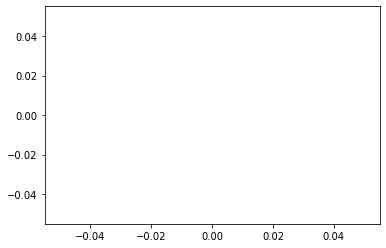

In [145]:
plt.plot(playerX.policy_trainer.scores)
plt.show()

In [146]:
playerX.policy_trainer.Q

{'[ 1 -1 -1  1  0  0  0 -1  1]': array([0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 1.00, 0.00, 0.00]),
 '[ 0 -1 -1  1  0  0  0  0  1]': array([0.90, 0.00, 0.00, 0.00, -1.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 0  0 -1  0  0  0  0  0  1]': array([0.90, 0.36, 0.00, 0.00, 0.00, 0.00, 0.81, 0.00, 0.00]),
 '[0 0 0 0 0 0 0 0 0]': array([0.81, 0.33, 0.73, 0.73, 0.33, 0.33, 0.73, 0.81, 0.73]),
 '[ 1  0  1  0 -1  0  0 -1  0]': array([0.00, 1.00, 0.00, -1.00, 0.00, 0.90, -1.00, 0.00, -1.00]),
 '[ 0  0  1  0 -1  0  0  0  0]': array([0.36, 0.36, 0.00, 0.36, 0.00, 0.36, 0.00, 0.81, 0.36]),
 '[ 0 -1  1 -1 -1  1  1  1 -1]': array([0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 0  0  1 -1 -1  1  1  0 -1]': array([0.45, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.45, 0.00]),
 '[ 0  0  1 -1  0  1  0  0 -1]': array([0.41, 0.81, 0.00, 0.00, 0.81, 0.00, 0.41, 0.00, 0.00]),
 '[ 0  0  1 -1  0  0  0  0  0]': array([0.81, 0.00, 0.00, 0.00, 0.81, 0.73, 0.90, 0.81, 0.90]),
 '[ 1 -1 -1  0  1  1 -1  1 -1]': array([0.00,

In [147]:
playerO.policy_trainer.Q

{'[ 1 -1 -1  1  0  0  0  0  1]': array([0.00, 0.00, 0.00, 0.00, -1.00, 0.00, -1.00, -1.00, 0.00]),
 '[ 0  0 -1  1  0  0  0  0  1]': array([0.90, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.81, 0.00]),
 '[0 0 0 0 0 0 0 0 1]': array([0.36, 0.36, 0.00, 0.00, 0.36, 0.36, 0.36, 0.36, 0.00]),
 '[ 1  0  1  0 -1  0  0  0  0]': array([0.00, 0.41, 0.00, 0.00, 0.00, -1.00, -1.00, -1.00, 0.81]),
 '[0 0 1 0 0 0 0 0 0]': array([0.00, 0.36, 0.00, 0.00, 0.73, 0.36, 0.00, 0.00, 0.00]),
 '[ 0  0  1 -1 -1  1  1  1 -1]': array([0.00, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 0  0  1 -1  0  1  1  0 -1]': array([-1.00, -1.00, 0.00, 0.00, 0.45, 0.00, 0.00, -1.00, 0.00]),
 '[ 0  0  1 -1  0  1  0  0  0]': array([-1.00, -1.00, 0.00, 0.00, -1.00, 0.00, -1.00, -1.00, 0.81]),
 '[ 1  0 -1  0  1  1 -1  1 -1]': array([0.00, -1.00, 0.00, -1.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 1  0 -1  0  0  1 -1  1  0]': array([0.00, 0.00, 0.00, 0.90, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 1  0  0  0  0  0 -1  1  0]': array([0.

### How the episodes settle the Q-values

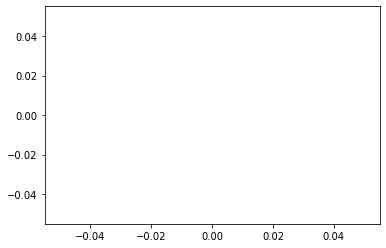

In [148]:
plt.plot(playerX.policy_trainer.scores)
plt.show()

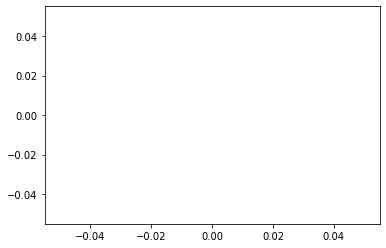

In [149]:
plt.plot(playerO.policy_trainer.scores)
plt.show()

### Trained Q-values for Player X


In [150]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [151]:
playerX.policy_trainer.Q

{'[ 1 -1 -1  1  0  0  0 -1  1]': array([0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 1.00, 0.00, 0.00]),
 '[ 0 -1 -1  1  0  0  0  0  1]': array([0.90, 0.00, 0.00, 0.00, -1.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 0  0 -1  0  0  0  0  0  1]': array([0.90, 0.36, 0.00, 0.00, 0.00, 0.00, 0.81, 0.00, 0.00]),
 '[0 0 0 0 0 0 0 0 0]': array([0.81, 0.33, 0.73, 0.73, 0.33, 0.33, 0.73, 0.81, 0.73]),
 '[ 1  0  1  0 -1  0  0 -1  0]': array([0.00, 1.00, 0.00, -1.00, 0.00, 0.90, -1.00, 0.00, -1.00]),
 '[ 0  0  1  0 -1  0  0  0  0]': array([0.36, 0.36, 0.00, 0.36, 0.00, 0.36, 0.00, 0.81, 0.36]),
 '[ 0 -1  1 -1 -1  1  1  1 -1]': array([0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 0  0  1 -1 -1  1  1  0 -1]': array([0.45, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.45, 0.00]),
 '[ 0  0  1 -1  0  1  0  0 -1]': array([0.41, 0.81, 0.00, 0.00, 0.81, 0.00, 0.41, 0.00, 0.00]),
 '[ 0  0  1 -1  0  0  0  0  0]': array([0.81, 0.00, 0.00, 0.00, 0.81, 0.73, 0.90, 0.81, 0.90]),
 '[ 1 -1 -1  0  1  1 -1  1 -1]': array([0.00,

### Trained Q-values for Player O

In [152]:
playerO.policy_trainer.Q

{'[ 1 -1 -1  1  0  0  0  0  1]': array([0.00, 0.00, 0.00, 0.00, -1.00, 0.00, -1.00, -1.00, 0.00]),
 '[ 0  0 -1  1  0  0  0  0  1]': array([0.90, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.81, 0.00]),
 '[0 0 0 0 0 0 0 0 1]': array([0.36, 0.36, 0.00, 0.00, 0.36, 0.36, 0.36, 0.36, 0.00]),
 '[ 1  0  1  0 -1  0  0  0  0]': array([0.00, 0.41, 0.00, 0.00, 0.00, -1.00, -1.00, -1.00, 0.81]),
 '[0 0 1 0 0 0 0 0 0]': array([0.00, 0.36, 0.00, 0.00, 0.73, 0.36, 0.00, 0.00, 0.00]),
 '[ 0  0  1 -1 -1  1  1  1 -1]': array([0.00, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 0  0  1 -1  0  1  1  0 -1]': array([-1.00, -1.00, 0.00, 0.00, 0.45, 0.00, 0.00, -1.00, 0.00]),
 '[ 0  0  1 -1  0  1  0  0  0]': array([-1.00, -1.00, 0.00, 0.00, -1.00, 0.00, -1.00, -1.00, 0.81]),
 '[ 1  0 -1  0  1  1 -1  1 -1]': array([0.00, -1.00, 0.00, -1.00, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 1  0 -1  0  0  1 -1  1  0]': array([0.00, 0.00, 0.00, 0.90, 0.00, 0.00, 0.00, 0.00, 0.00]),
 '[ 1  0  0  0  0  0 -1  1  0]': array([0.